# 정부안 분석

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
import hanja
from krwordrank.hangle import normalize
import datetime
%matplotlib inline

In [2]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [3]:
gender = pd.read_csv('whole-gender-bill-1320.csv', index_col=0,
                           parse_dates=['제안일자','의결일자'],encoding='utf-8-sig')
print(gender.shape)
gender.head(1)

(4295, 16)


의안번호         의안명       제안일자 제안자구분       의결일자  의결결과  \
0  131131  소득세법중개정법률안 1990-12-17   위원장 1990-12-18  원안가결   

                     제안회기                                               제안이유  \
0  제13대 (1988~1992) 제151회     정부제출,柳인학·강金식·금봉욱·林춘원·李경재·허만기·홍영기의원외64인 발의,1...   

   소관위원회 제안자  발의자 제안정당   성별  여성의원 수 정당성향  국회회기  
0  재무위원회  []  위원장  위원장  NaN       0  NaN    13

In [4]:
gender['제안일자'] = gender['제안일자'].dt.date
gender['의결일자'] = gender['의결일자'].dt.date

In [5]:
gender['제안일자'].unique()

array([datetime.date(1990, 12, 17), datetime.date(1990, 11, 20),
       datetime.date(1990, 10, 8), ..., datetime.date(2016, 6, 1),
       datetime.date(2016, 5, 31), datetime.date(2016, 5, 30)],
      dtype=object)

## 정부안 wordcloud

In [6]:
gender['제안자구분'].value_counts()

의원     3766
위원장     345
정부      184
Name: 제안자구분, dtype: int64

In [7]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명','보장하',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자',
            '조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출']

    text = [word for word in text if word not in stopwords]
    return text

In [8]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [9]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 277 ms, sys: 4.52 ms, total: 282 ms
Wall time: 314 ms


In [10]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [11]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 2min 52s, sys: 1.97 s, total: 2min 54s
Wall time: 2min 45s


0    [소득세법중개정법률, 정부제출, 인학, 금봉욱, 춘원, 경재, 허만기, 홍영기의원외...
1    [특정범죄가중처벌등에관한법률중개정법률안, 정부, 제출, 각특정범죄가중처벌등에관한법률...
2    [유아의보호, 교육에관한법률안, 현대사회, 산업화, 여성, 사회참여, 가족구조, 핵...
Name: tokens, dtype: object

In [12]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 1.47 s, sys: 15.8 ms, total: 1.48 s
Wall time: 1.53 s


In [13]:
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 1.86 ms, sys: 77 µs, total: 1.93 ms
Wall time: 1.88 ms


In [14]:
# 명사 수가 10개를 넘어가는 경우만 추출
#gender = gender[gender['명사수'] >= 10]
#gender = gender.reset_index(drop=True)
#print(gender.shape)

## 정권 탐색 

### 노태우 정권 
- 1998.02.25 ~ 1993.02.24

In [174]:
notaewoo = gender[(gender['제안일자'] > datetime.date(1988,5,3)) & 
                        (gender['제안일자'] < datetime.date(1993,2,24))]
notaewoo.shape

(23, 19)

In [175]:
notaewoo['제안자구분'].value_counts()

의원     13
위원장     6
정부      4
Name: 제안자구분, dtype: int64

In [176]:
government = notaewoo[notaewoo['제안자구분'] == '정부']
government.shape

(4, 19)

In [177]:
government

의안번호                   의안명        제안일자 제안자구분        의결일자    의결결과  \
4   131006  특정범죄가중처벌등에관한법률중개정법률안  1990-10-08    정부  1990-12-18  대안반영폐기   
5   130999            소득세법중개정법률안  1990-09-28    정부  1990-12-18  대안반영폐기   
18  140049            소득세법중개정법률안  1992-10-02    정부  1992-11-20    수정가결   
21  140013               형법개정법률안  1992-07-07    정부  1995-12-02  대안반영폐기   

                      제안회기                                               제안이유  \
4   제13대 (1988~1992) 제151회     민생치안확립에 기여하게 하기 위하여 흉기 등을 휴대한 강간 등 행위에 대하여 ...   
5   제13대 (1988~1992) 제151회     땀흘려 일하여 얻은 근로소득에 대하여는 세부담을 경감하고 不동산양도소득 등의 ...   
18  제14대 (1992~1996) 제159회  임金수준의 전반적인 상승, 소득계층구조의 변화와 정부의 임金안정화 시책 등을 감안하...   
21  제14대 (1992~1996) 제157회  1953년 형법 제정이래 정치·경제·사회등 모든 영역의 발전과 윤리의식의 변화로 발...   

      소관위원회 제안자 발의자 제안정당   성별  여성의원 수 정당성향  국회회기  \
4   법제사법위원회  []  정부   정부  NaN       0  NaN    13   
5     재무위원회  []  정부   정부  NaN       0  NaN    13   
18    재무위원회  []  정부   정부  NaN       0  NaN    14   
21  법제사법위원회  []  정부   정부  NaN       0  NaN    14   

                                                의안텍스트  \
4   특정범죄가중처벌등에관한법률중개정법률안    민생치안확립에 기여하게 하기 위하여 흉기...   
5   소득세법중개정법률안    땀흘려 일하여 얻은 근로소득에 대하여는 세부담을 경감하고 ...   
18  소득세법중개정법률안 임 수준의 전반적인 상승  소득계층구조의 변화와 정부의 임 안정...   
21  형법개정법률안     년 형법 제정이래 정치 경제 사회등 모든 영역의 발전과 윤리의...   

                                               tokens  명사수  
4   [특정범죄가중처벌등에관한법률중개정법률안, 민생치안확립, 흉기, 휴대, 강간, 행위,...  110  
5   [소득세법중개정법률, 근로소득, 세부담, 경감, 동산양도소득, 자산소득, 과세를강화...  210  
18  [소득세법중개정법률, 수준, 전반적, 상승, 소득계층구조, 변화, 정부, 안정화, ...  280  
21  [형법개정법률안, 형법, 제정, 정치, 경제, 사회등, 영역, 발전, 윤리의식, 변...  423

In [178]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [180]:
model_government = Word2Vec(government['tokens'], size=100, window = 10, min_count=0, workers=4, iter=100, sg=1)
print(model_government.wv.most_similar('여성'))

2020-10-13 23:58:44,964 : INFO : collecting all words and their counts
2020-10-13 23:58:44,966 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-13 23:58:44,968 : INFO : collected 665 word types from a corpus of 1023 raw words and 4 sentences
2020-10-13 23:58:44,969 : INFO : Loading a fresh vocabulary
2020-10-13 23:58:44,972 : INFO : effective_min_count=0 retains 665 unique words (100% of original 665, drops 0)
2020-10-13 23:58:44,974 : INFO : effective_min_count=0 leaves 1023 word corpus (100% of original 1023, drops 0)
2020-10-13 23:58:44,978 : INFO : deleting the raw counts dictionary of 665 items
2020-10-13 23:58:44,979 : INFO : sample=0.001 downsamples 72 most-common words
2020-10-13 23:58:44,980 : INFO : downsampling leaves estimated 908 word corpus (88.8% of prior 1023)
2020-10-13 23:58:44,984 : INFO : estimated required memory for 665 words and 100 dimensions: 864500 bytes
2020-10-13 23:58:44,987 : INFO : resetting layer weights
2020-10-13 23:58

2020-10-13 23:58:45,430 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:58:45,431 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:58:45,433 : INFO : EPOCH - 15 : training on 1023 raw words (913 effective words) took 0.0s, 80881 effective words/s
2020-10-13 23:58:45,442 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:58:45,443 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:58:45,446 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:58:45,447 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:58:45,448 : INFO : EPOCH - 16 : training on 1023 raw words (907 effective words) took 0.0s, 69838 effective words/s
2020-10-13 23:58:45,455 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:58:45,457 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 2

2020-10-13 23:58:45,729 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:58:45,731 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:58:45,733 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:58:45,739 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:58:45,740 : INFO : EPOCH - 32 : training on 1023 raw words (906 effective words) took 0.0s, 73398 effective words/s
2020-10-13 23:58:45,747 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:58:45,751 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:58:45,753 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:58:45,758 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:58:45,760 : INFO : EPOCH - 33 : training on 1023 raw words (910 effective words) took 0.0s, 69286 effective words/s
2020-10-13 2

2020-10-13 23:58:46,072 : INFO : EPOCH - 48 : training on 1023 raw words (911 effective words) took 0.0s, 51680 effective words/s
2020-10-13 23:58:46,085 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:58:46,092 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:58:46,094 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:58:46,096 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:58:46,096 : INFO : EPOCH - 49 : training on 1023 raw words (910 effective words) took 0.0s, 80846 effective words/s
2020-10-13 23:58:46,099 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:58:46,102 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:58:46,103 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:58:46,108 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 2

2020-10-13 23:58:46,412 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:58:46,421 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:58:46,428 : INFO : EPOCH - 65 : training on 1023 raw words (905 effective words) took 0.0s, 35834 effective words/s
2020-10-13 23:58:46,431 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:58:46,434 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:58:46,437 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:58:46,443 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:58:46,450 : INFO : EPOCH - 66 : training on 1023 raw words (913 effective words) took 0.0s, 48441 effective words/s
2020-10-13 23:58:46,461 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:58:46,463 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 2

2020-10-13 23:58:46,700 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:58:46,702 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:58:46,704 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:58:46,707 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:58:46,708 : INFO : EPOCH - 82 : training on 1023 raw words (903 effective words) took 0.0s, 106943 effective words/s
2020-10-13 23:58:46,714 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:58:46,715 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:58:46,716 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:58:46,719 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:58:46,721 : INFO : EPOCH - 83 : training on 1023 raw words (901 effective words) took 0.0s, 90786 effective words/s
2020-10-13 

2020-10-13 23:58:46,975 : INFO : EPOCH - 98 : training on 1023 raw words (914 effective words) took 0.0s, 92994 effective words/s
2020-10-13 23:58:46,979 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:58:46,980 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:58:46,984 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:58:46,987 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:58:46,988 : INFO : EPOCH - 99 : training on 1023 raw words (917 effective words) took 0.0s, 94960 effective words/s
2020-10-13 23:58:46,991 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:58:46,992 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:58:46,995 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:58:47,000 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 2

KeyError: "word '여성' not in vocabulary"

In [159]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [160]:
government_word = total_tokens(government['tokens'])

In [44]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출','신설','한편','문제','지급','제공','항제','사용','근거','대상',
            '이유','증가','제도','사업','정책','우리나라','행위','특례법','불구','수준','추가','관리','확보','의무','업무','만원이하','세부담',
            '현재','보고','중요','규정함']
government_word = [each_word for each_word in government_word if each_word not in stopwords]

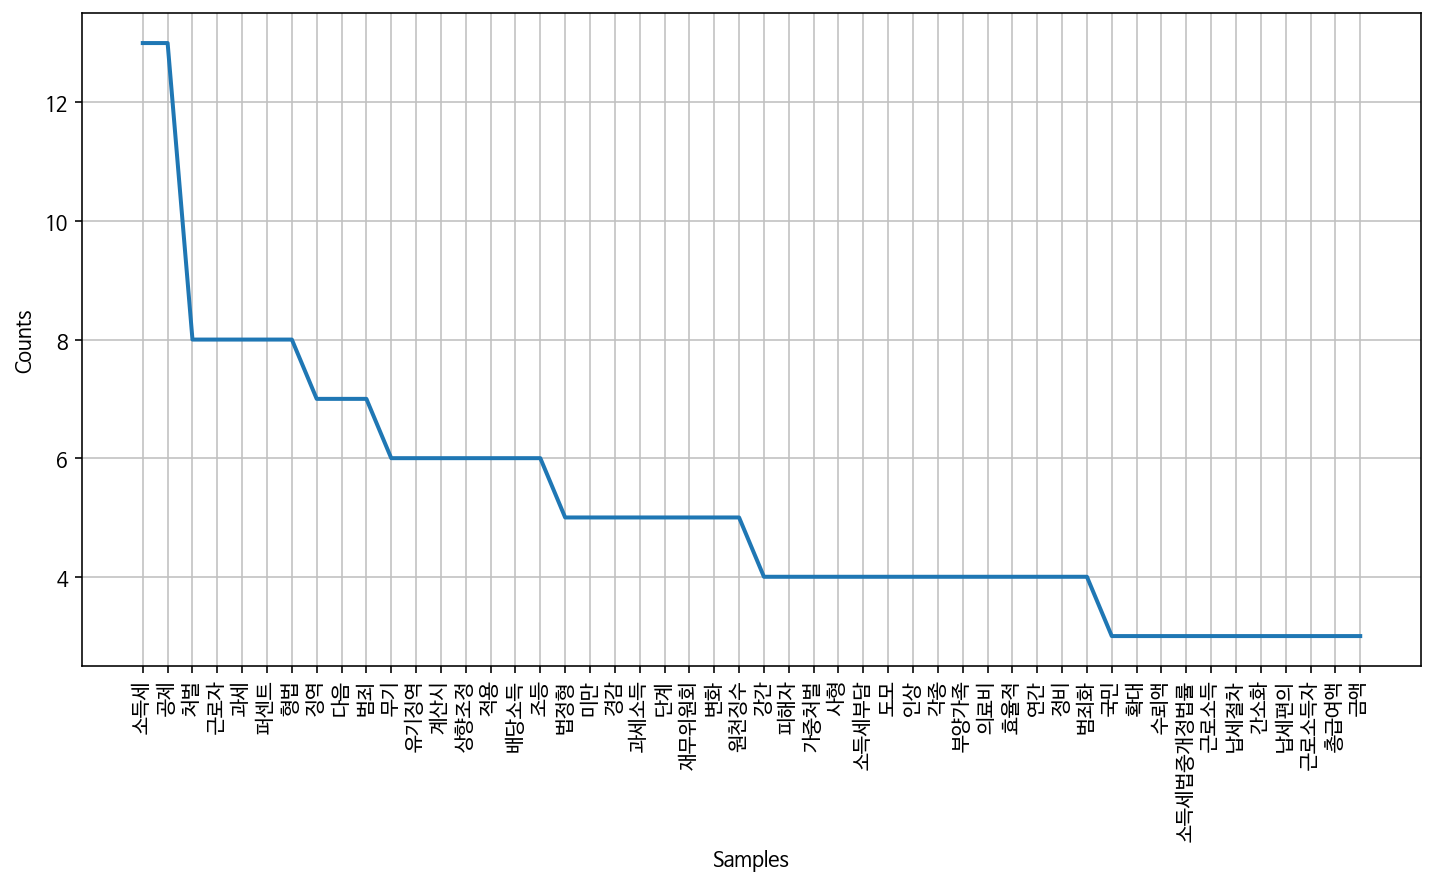

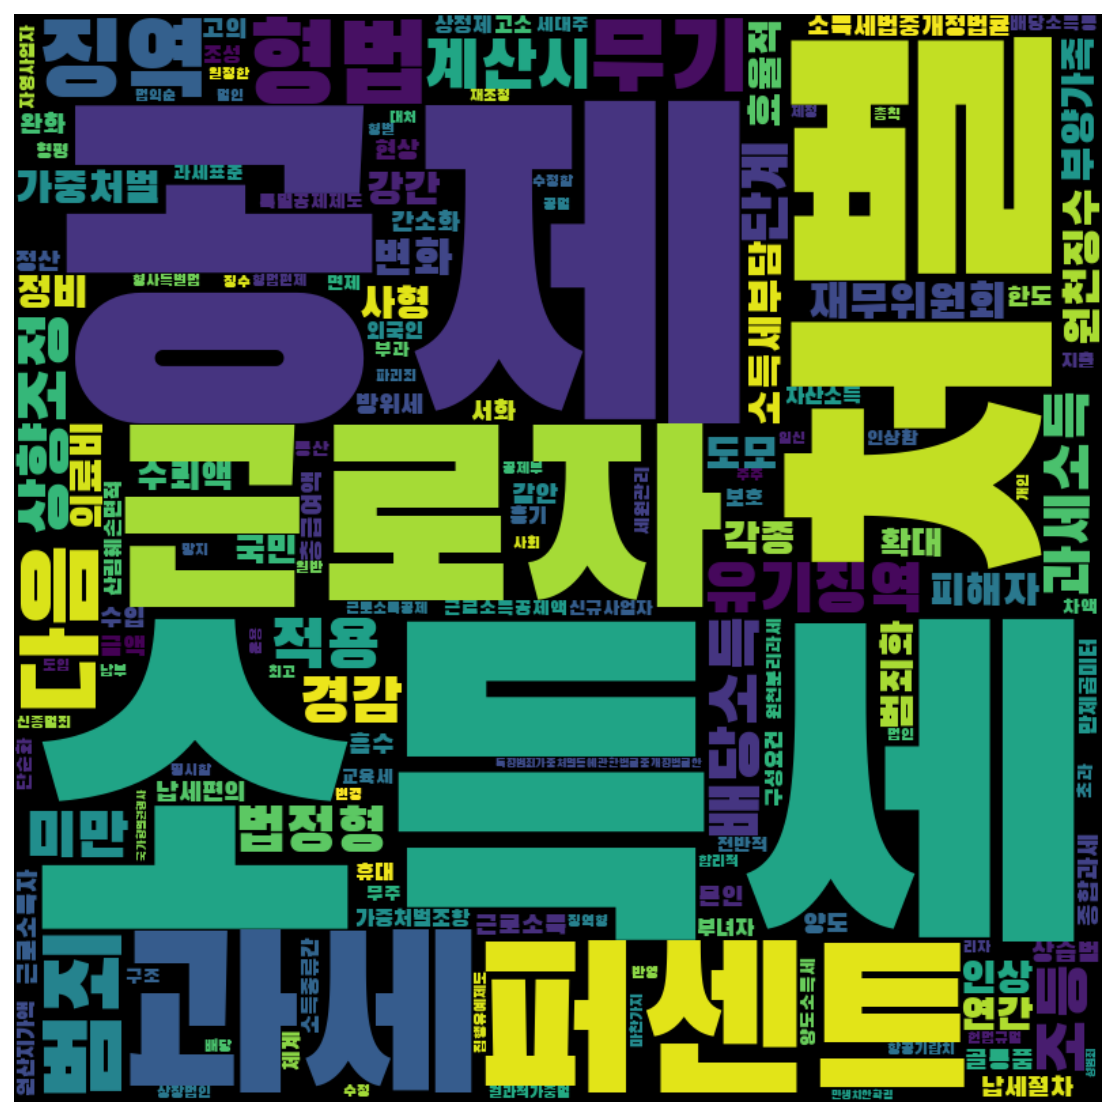

In [45]:
frewords_vis(government_word)
wordcloud_vis(government_word)

## 김영삼 정권 
- 1993.02.25 ~ 1998.02.24

In [181]:
kimyoungsam = gender[(gender['제안일자'] > datetime.date(1993,2,25)) & 
                        (gender['제안일자'] < datetime.date(1998,2,24))]
kimyoungsam.shape

(62, 19)

In [182]:
kimyoungsam['제안자구분'].value_counts()

의원     40
위원장    13
정부      9
Name: 제안자구분, dtype: int64

In [183]:
government = kimyoungsam[kimyoungsam['제안자구분'] == '정부']
government.shape

(9, 19)

In [184]:
government

의안번호                   의안명        제안일자 제안자구분        의결일자    의결결과  \
5   141166            소득세법중개정법률안  1995-09-30    정부  1995-12-02    수정가결   
9   140884          국가공무원법중개정법률안  1994-11-07    정부  1994-12-02    원안가결   
11  140857         윤락행위등방지법개정법률안  1994-11-01    정부  1994-12-16    수정가결   
12  140846          교육공무원법중개정법률안  1994-11-01    정부  1994-12-15    원안가결   
14  140443              고용정책기본법안  1993-10-20    정부  1993-12-01    원안가결   
15  140239  일제하일본군위안부에대한생활안정지원법안  1993-05-07    정부  1993-05-18    원안가결   
49  150838              국적법개정법률안  1997-11-08    정부  1997-11-18    수정가결   
74  150323    풍속영업의규제에관한법률중개정법률안  1996-11-20    정부  1997-02-18  대안반영폐기   
80  150122             상속세법개정법률안  1996-10-02    정부  1996-12-13    원안가결   

                      제안회기                                               제안이유  \
5   제14대 (1992~1996) 제177회  金융소득종합과세의 실효성을 높이기 위하여 채권등의 과세방식을 보완하고, 5년이상 장...   
9   제14대 (1992~1996) 제170회  공직사회에 일하는 분위기를 조성하기 위하여 사무관승진시험제도를 개선하고, 근무성적이...   
11  제14대 (1992~1996) 제170회  윤락행위자를 선도하기 위하여 선도보호시설에 입소시키는 법적근거를 명확히 하고 현실과...   
12  제14대 (1992~1996) 제170회  교사의 신규채용을 위한 공개전형을 실시함에 있어서 채용후 그가 담당할 직무를 적절히...   
14  제14대 (1992~1996) 제165회  산업구조의 고도화, 생산시설의 자동화, 국내외 경기의 변동등에 따라 급변하는 고용 ...   
15  제14대 (1992~1996) 제161회  한·일 양국간 현안과제의 하나인 일제하 일본군위안부문제를 보다 적극적으로 해결하기 ...   
49  제15대 (1996~2000) 제185회  현행법상의 부계혈통주의 조항은 헌법상 남녀평등의 원칙에 위배된다는 주장이 제기되어 ...   
74  제15대 (1996~2000) 제181회  미신고 풍속영업소에 대한 처벌규정을 강화하고, 청소년의 건전한 육성을 저해할 우려가...   
80  제15대 (1996~2000) 제181회  1950년에 상속세법이 제정된 이후, 그동안 소득수준의 향상, 인구의 노령화, 여성...   

      소관위원회 제안자 발의자 제안정당   성별  여성의원 수 정당성향  국회회기  \
5   재정경제위원회  []  정부   정부  NaN       0  NaN    14   
9   행정경제위원회  []  정부   정부  NaN       0  NaN    14   
11  보건사회위원회  []  정부   정부  NaN       0  NaN    14   
12    교육위원회  []  정부   정부  NaN       0  NaN    14   
14    노동위원회  []  정부   정부  NaN       0  NaN    14   
15  보건사회위원회  []  정부   정부  NaN       0  NaN    14   
49  법제사법위원회  []  정부   정부  NaN       0  NaN    15   
74    내무위원회  []  정부   정부  NaN       0  NaN    15   
80  재정경제위원회  []  정부   정부  NaN       0  NaN    15   

                                                의안텍스트  \
5   소득세법중개정법률안  융소득종합과세의 실효성을 높이기 위하여 채권등의 과세방식을 보...   
9   국가공무원법중개정법률안 공직사회에 일하는 분위기를 조성하기 위하여 사무관승진시험제도...   
11  윤락행위등방지법개정법률안 윤락행위자를 선도하기 위하여 선도보호시설에 입소시키는 법적...   
12  교육공무원법중개정법률안 교사의 신규채용을 위한 공개전형을 실시함에 있어서 채용후 그...   
14  고용정책기본법안 산업구조의 고도화  생산시설의 자동화  국내외 경기의 변동등에 따라...   
15  일제하일본군위안부에대한생활안정지원법안 한 일 양국간 현안과제의 하나인 일제하 일본군...   
49  국적법개정법률안 현행법상의 부계혈통주의 조항은 헌법상 남녀평등의 원칙에 위배된다는 ...   
74  풍속영업의규제에관한법률중개정법률안 미신고 풍속영업소에 대한 처벌규정을 강화하고  청...   
80  상속세법개정법률안     년에 상속세법이 제정된 이후  그동안 소득수준의 향상  인...   

                                               tokens  명사수  
5   [소득세법중개정법률, 융소득종합과세, 실효성, 채권등, 과세방식, 보완, 장기저축,...  170  
9   [국가공무원법중개정법률, 공직사회, 분위기, 조성, 사무관승진시험제도, 개선, 근무...   98  
11  [윤락행위등방지법개정법률안, 윤락행위자, 선도하기, 선도보호시설, 입소, 법적근거,...  114  
12  [교육공무원법중개정법률, 교사, 신규채용, 공개전형, 채용후, 담당, 직무, 수행,...  106  
14  [고용정책기본법안, 산업구조, 고도화, 생산시설, 자동화, 국내외, 경기, 변동등,...  133  
15  [일제하일본군위안부에대한생활안정지원법안, 양국간, 현안과제, 하나, 일제하, 일본군...   77  
49  [국적법개정법률안, 현행법상, 부계혈통주의, 조항, 헌법상, 남녀평등, 원칙, 위배...  161  
74  [풍속영업의규제에관한법률중개정법률안, 미신, 풍속영업소, 처벌규정, 강화, 청소년,...   53  
80  [상속세법개정법률안, 상속세법, 제정, 이후, 그동안, 소득수준, 향상, 인구, 노...  181

In [185]:
model_government = Word2Vec(government['tokens'], size=100, window = 10, min_count=0, workers=4, iter=100, sg=1)
print(model_government.wv.most_similar('여성'))

2020-10-13 23:59:29,439 : INFO : collecting all words and their counts
2020-10-13 23:59:29,441 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-13 23:59:29,444 : INFO : collected 693 word types from a corpus of 1093 raw words and 9 sentences
2020-10-13 23:59:29,445 : INFO : Loading a fresh vocabulary
2020-10-13 23:59:29,448 : INFO : effective_min_count=0 retains 693 unique words (100% of original 693, drops 0)
2020-10-13 23:59:29,450 : INFO : effective_min_count=0 leaves 1093 word corpus (100% of original 1093, drops 0)
2020-10-13 23:59:29,454 : INFO : deleting the raw counts dictionary of 693 items
2020-10-13 23:59:29,455 : INFO : sample=0.001 downsamples 84 most-common words
2020-10-13 23:59:29,456 : INFO : downsampling leaves estimated 1000 word corpus (91.5% of prior 1093)
2020-10-13 23:59:29,459 : INFO : estimated required memory for 693 words and 100 dimensions: 900900 bytes
2020-10-13 23:59:29,462 : INFO : resetting layer weights
2020-10-13 23:5

2020-10-13 23:59:29,968 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:59:29,972 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:59:29,973 : INFO : EPOCH - 15 : training on 1093 raw words (992 effective words) took 0.0s, 83682 effective words/s
2020-10-13 23:59:29,979 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:59:29,983 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:59:29,989 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:59:29,993 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:59:29,995 : INFO : EPOCH - 16 : training on 1093 raw words (1000 effective words) took 0.0s, 57411 effective words/s
2020-10-13 23:59:30,001 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:59:30,004 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 

2020-10-13 23:59:30,342 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:59:30,347 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:59:30,351 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:59:30,354 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:59:30,355 : INFO : EPOCH - 32 : training on 1093 raw words (1014 effective words) took 0.0s, 78484 effective words/s
2020-10-13 23:59:30,359 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:59:30,366 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:59:30,368 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:59:30,371 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:59:30,371 : INFO : EPOCH - 33 : training on 1093 raw words (990 effective words) took 0.0s, 79189 effective words/s
2020-10-13 

2020-10-13 23:59:30,620 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:59:30,622 : INFO : EPOCH - 48 : training on 1093 raw words (997 effective words) took 0.0s, 65695 effective words/s
2020-10-13 23:59:30,637 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:59:30,642 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:59:30,648 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:59:30,651 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:59:30,652 : INFO : EPOCH - 49 : training on 1093 raw words (984 effective words) took 0.0s, 61290 effective words/s
2020-10-13 23:59:30,655 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:59:30,661 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:59:30,665 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 2

2020-10-13 23:59:30,929 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:59:30,932 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:59:30,932 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:59:30,934 : INFO : EPOCH - 65 : training on 1093 raw words (1004 effective words) took 0.0s, 94012 effective words/s
2020-10-13 23:59:30,949 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:59:30,951 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:59:30,952 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:59:30,953 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:59:30,959 : INFO : EPOCH - 66 : training on 1093 raw words (1001 effective words) took 0.0s, 61188 effective words/s
2020-10-13 23:59:30,970 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13

2020-10-13 23:59:31,211 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:59:31,213 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:59:31,214 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:59:31,221 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:59:31,223 : INFO : EPOCH - 82 : training on 1093 raw words (1013 effective words) took 0.0s, 86099 effective words/s
2020-10-13 23:59:31,234 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:59:31,241 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:59:31,243 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:59:31,247 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:59:31,252 : INFO : EPOCH - 83 : training on 1093 raw words (1009 effective words) took 0.0s, 54744 effective words/s
2020-10-13

2020-10-13 23:59:31,548 : INFO : EPOCH - 98 : training on 1093 raw words (1010 effective words) took 0.0s, 90042 effective words/s
2020-10-13 23:59:31,556 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:59:31,557 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:59:31,558 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:59:31,563 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-13 23:59:31,565 : INFO : EPOCH - 99 : training on 1093 raw words (1007 effective words) took 0.0s, 110106 effective words/s
2020-10-13 23:59:31,571 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-13 23:59:31,575 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-13 23:59:31,577 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-13 23:59:31,579 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-1

[('인구', 0.8090914487838745), ('경제', 0.8074588775634766), ('사회적', 0.8045456409454346), ('청소년등', 0.7982962131500244), ('장애', 0.7971746921539307), ('노령화', 0.790184497833252), ('지위향상', 0.7900159955024719), ('소득수준', 0.7887955904006958), ('단독귀화를금지하', 0.7876319885253906), ('고령자', 0.7855069041252136)]


In [165]:
government_word = total_tokens(government['tokens'])

In [166]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출','신설','한편','문제','지급','제공','항제','사용','근거','대상',
            '이유','증가','제도','사업','정책','우리나라','행위','특례법','불구','수준','추가','관리','확보','의무','업무','퍼센트']
government_word = [each_word for each_word in government_word if each_word not in stopwords]

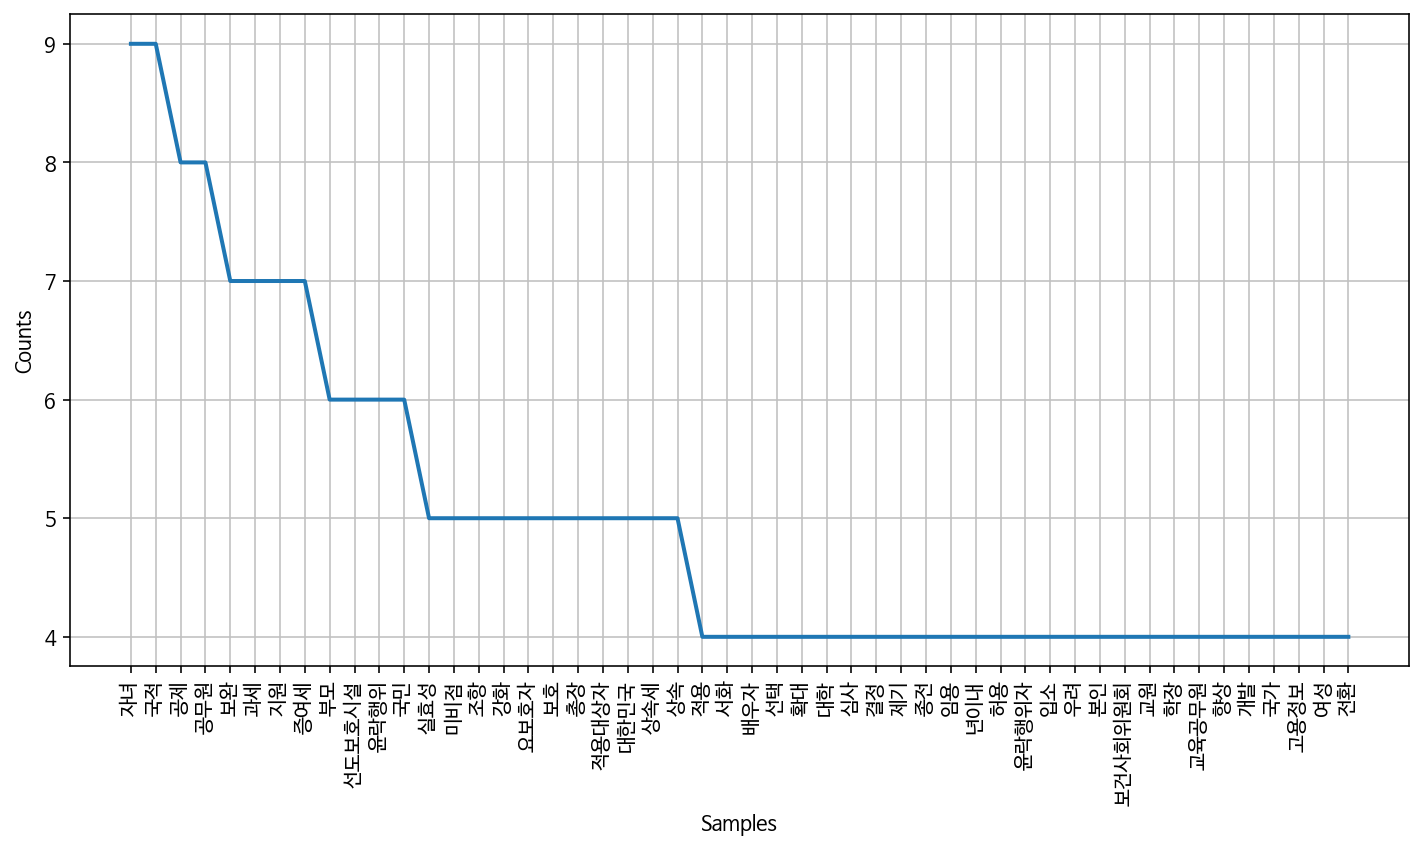

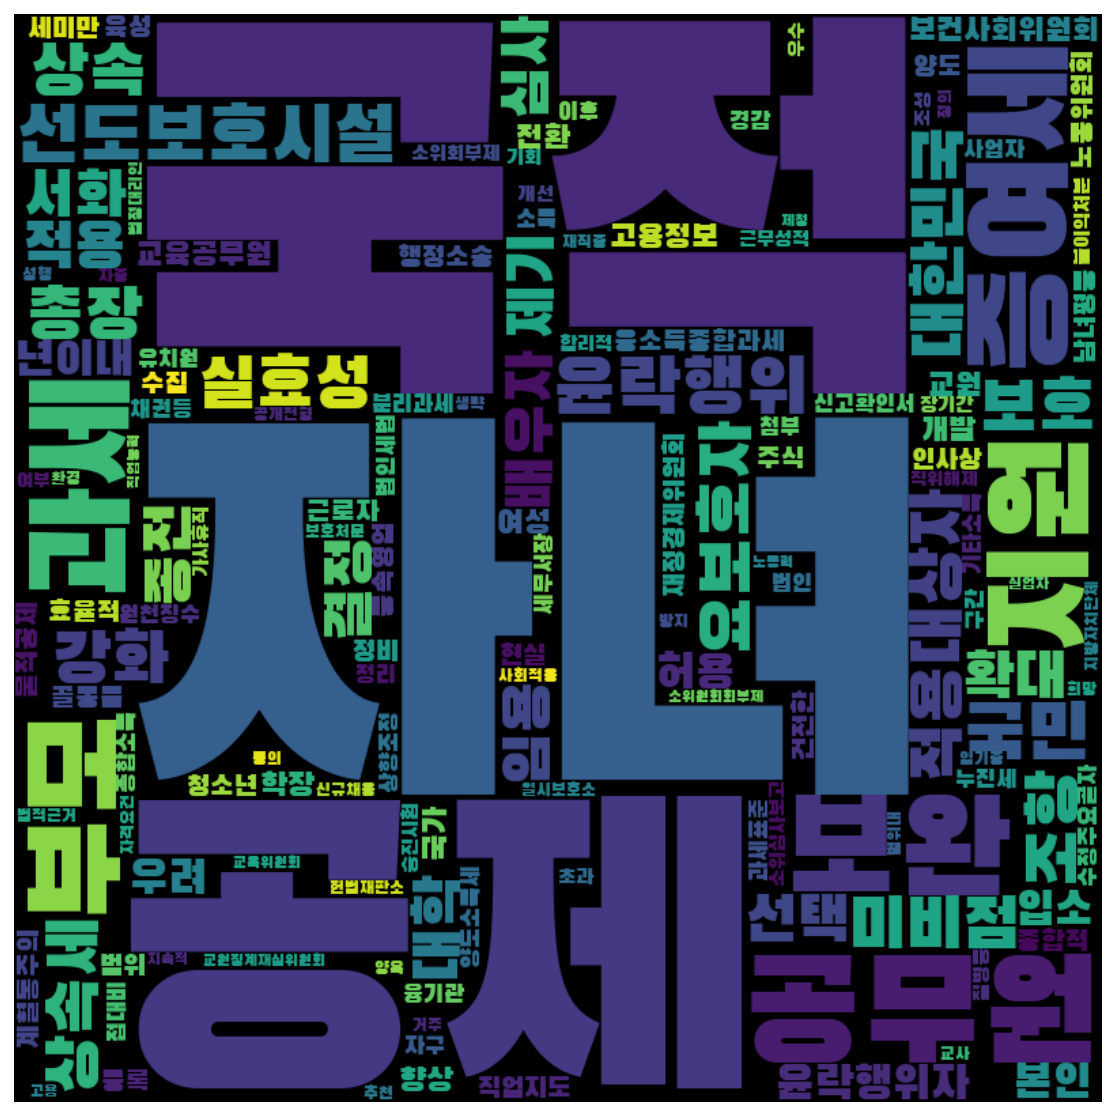

In [167]:
frewords_vis(government_word)
wordcloud_vis(government_word)

## 김대중 정권 
- 1998.02.25 ~ 2003.02.24

In [186]:
kimdaejoong = gender[(gender['제안일자'] > datetime.date(1998,2,25)) & 
                        (gender['제안일자'] < datetime.date(2003,2,24))]
kimdaejoong.shape

(92, 19)

In [187]:
kimdaejoong['제안자구분'].value_counts()

의원     54
정부     20
위원장    18
Name: 제안자구분, dtype: int64

In [188]:
government = kimdaejoong[kimdaejoong['제안자구분'] == '정부']
government.shape

(20, 19)

In [189]:
government

의안번호                     의안명        제안일자 제안자구분        의결일자    의결결과  \
16  152008              소득세법중개정법률안  1999-07-05    정부  1999-08-12    수정가결   
29  151472               농업·농촌기본법안  1998-11-27    정부  1998-12-29    수정가결   
31  151372             모자복지법중개정법률안  1998-11-17    정부  1998-12-11    수정가결   
32  151344                민법중개정법률안  1998-11-13    정부  2000-05-29  임기만료폐기   
33  151337             모자보건법중개정법률안  1998-11-11    정부  1999-01-06  대안반영폐기   
42  162045            교육공무원법중개정법률안  2003-01-02    정부  2003-06-30    수정가결   
45  161853  가정폭력범죄의처벌등에관한특례법중개정법률안  2002-10-21    정부  2002-11-07    수정가결   
46  161765      여성과학기술인육성및지원에관한법률안  2002-10-04    정부  2002-11-12    수정가결   
47  161748             발명진흥법중개정법률안  2002-09-25    정부  2002-11-12    원안가결   
51  161554            지방공무원법중개정법률안  2002-04-23    정부  2002-11-07    수정가결   
58  161364    남녀차별금지및구제에관한법률중개정법률안  2001-12-21    정부  2003-04-30    수정가결   
64  161131           여성발전기본법중개정법률안  2001-11-12    정부  2002-11-07  대안반영폐기   
66  161100            국가공무원법중개정법률안  2001-11-05    정부  2001-12-20    원안가결   
74  160603            청소년보호법중개정법률안  2001-01-26    정부  2001-04-26    수정가결   
83  160324  국가유공자등예우및지원에관한법률중개정법률안  2000-11-20    정부  2000-12-15  대안반영폐기   
84  160323      독립유공자예우에관한법률중개정법률안  2000-11-20    정부  2000-12-15  대안반영폐기   
85  160214                민법중개정법률안  2000-10-16    정부  2004-05-29  임기만료폐기   
86  160211                과학기술기본법안  2000-10-14    정부  2000-12-15    수정가결   
90  160062    남녀차별금지및구제에관한법률중개정법률안  2000-07-06    정부  2000-12-27    원안가결   
91  160061             정부조직법중개정법률안  2000-07-06    정부  2000-12-27    수정가결   

                      제안회기                                               제안이유  \
16  제15대 (1996~2000) 제205회  중산층  서민생활안정 대책의 일환으로 소득이 투명하게 노출되는 봉급생 활자들의 세부...   
29  제15대 (1996~2000) 제198회  개방·경쟁시대에 대응하여 우리 농업의 경쟁력을 높이고 공익적 기능을 강화하여 농업을...   
31  제15대 (1996~2000) 제198회  운영실적이 저조한 중앙모자복지위원회를 폐지하고, 국가·지방자치단체, 사회복지법인  ...   
32  제15대 (1996~2000) 제198회  헌법재판소에서 민법의 동성동본 금혼규정에 대하여 헌법不합치결정을 하고 금년말까지 이...   
33  제15대 (1996~2000) 제198회        우생학적 또는 유전학적 정신장애나 신체질환의 유전 또는 전염의 방지를 위...   
42  제16대 (2000~2004) 제235회        대학의 교원임용에 있어서 남녀평등을 제고하기 위하여 국 공립 대학의 장은...   
45  제16대 (2000~2004) 제234회   " 가정폭력범죄에 대하여 검사(검사)는 피해자의 주거 등으로부터 100미터 이내의...   
46  제16대 (2000~2004) 제234회     지식기반사회에서는 고도의 전문성과 창의성을 지닌 우수한 과학기술인력의 충분한 ...   
47  제16대 (2000~2004) 제234회     기업과 국가의 경쟁력이 지식과 정보에 의하여 결정되는 지식경제시대(지식경제시대...   
51  제16대 (2000~2004) 제229회     지식정보화사회의 변화에 적극 대응하여 지방공무원이 지방자치발전을 이끄는 중추적...   
58  제16대 (2000~2004) 제226회     남녀차별의 개념을 명확하게 하기 위하여 직접적으로 남녀를 차별하는 외에 간접적...   
64  제16대 (2000~2004) 제225회    제안이유？？？？여성정책에 대한 새로운 요구가 다양하게 제기됨에 따라 동 정책의 ...   
66  제16대 (2000~2004) 제225회     21세기 급속한 사회변화에 적극 대응하여 공무원이 국가발전을 이끄는 중추적 역...   
74  제16대 (2000~2004) 제217회     사회통념상 성인으로 간주되는 대학생·근로청소년들이 자유롭게 사회활동을 할 수 ...   
83  제16대 (2000~2004) 제215회    제안이유？？？？국가유공자의 출가한 딸은 극히 예외적인 경우에만 의료보호 등의 보...   
84  제16대 (2000~2004) 제215회    제안이유？？？？독립유공자의 출가한 딸 또는 출가한 손녀는 극히 예외적인경우에만 ...   
85  제16대 (2000~2004) 제215회     친족편에 있어서 헌법재판소가 헌법불합치결정을 한 동성동본금혼제도를 폐지하는 등...   
86  제16대 (2000~2004) 제215회     과학기술이 핵심이 되는 지식기반경제사회에 걸맞게 과학기술에 관한 이념과 발전방...   
90  제16대 (2000~2004) 제213회     정부조직개편으로 女성특별위원회가 폐지되고 女성부가 신설될 예정이므로 남녀차별금...   
91  제16대 (2000~2004) 제213회     새 천년의 요구에 맞는 경쟁력있고 효율적인 정부를 구현하기 위하여 국가 핵심力...   

          소관위원회 제안자 발의자 제안정당   성별  여성의원 수 정당성향  국회회기  \
16      재정경제위원회  []  정부   정부  NaN       0  NaN    15   
29    농림해양수산위원회  []  정부   정부  NaN       0  NaN    15   
31      보건복지위원회  []  정부   정부  NaN       0  NaN    15   
32      법제사법위원회  []  정부   정부  NaN       0  NaN    15   
33      보건복지위원회  []  정부   정부  NaN       0  NaN    15   
42        교육위원회  []  정부   정부  NaN       0  NaN    16   
45      법제사법위원회  []  정부   정부  NaN       0  NaN    16   
46  과학기술정보통신위원회  []  정부   정부  NaN       0  NaN    16   
47      산업자원위원회  []  정부   정부  NaN       0  NaN    16   
51      행정자치위원회  []  정부   정부  NaN       0  NaN    16   
58      국회운영위원회  []  정부   정부  NaN       0  NaN    16   
64      국회운영위원회  []  정부   정부  NaN  

In [190]:
model_government = Word2Vec(government['tokens'], size=100, window = 10, min_count=0, workers=4, iter=100, sg=1)

2020-10-14 00:00:49,372 : INFO : collecting all words and their counts
2020-10-14 00:00:49,374 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-14 00:00:49,376 : INFO : collected 1125 word types from a corpus of 2439 raw words and 20 sentences
2020-10-14 00:00:49,378 : INFO : Loading a fresh vocabulary
2020-10-14 00:00:49,382 : INFO : effective_min_count=0 retains 1125 unique words (100% of original 1125, drops 0)
2020-10-14 00:00:49,383 : INFO : effective_min_count=0 leaves 2439 word corpus (100% of original 2439, drops 0)
2020-10-14 00:00:49,388 : INFO : deleting the raw counts dictionary of 1125 items
2020-10-14 00:00:49,389 : INFO : sample=0.001 downsamples 49 most-common words
2020-10-14 00:00:49,390 : INFO : downsampling leaves estimated 2267 word corpus (93.0% of prior 2439)
2020-10-14 00:00:49,395 : INFO : estimated required memory for 1125 words and 100 dimensions: 1462500 bytes
2020-10-14 00:00:49,396 : INFO : resetting layer weights
2020-10-

2020-10-14 00:00:50,099 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:00:50,118 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:00:50,119 : INFO : EPOCH - 15 : training on 2439 raw words (2270 effective words) took 0.0s, 93341 effective words/s
2020-10-14 00:00:50,127 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:00:50,128 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:00:50,131 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:00:50,149 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:00:50,151 : INFO : EPOCH - 16 : training on 2439 raw words (2280 effective words) took 0.0s, 93774 effective words/s
2020-10-14 00:00:50,157 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:00:50,158 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14

2020-10-14 00:00:50,553 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:00:50,556 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:00:50,561 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:00:50,572 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:00:50,573 : INFO : EPOCH - 32 : training on 2439 raw words (2265 effective words) took 0.0s, 117203 effective words/s
2020-10-14 00:00:50,578 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:00:50,581 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:00:50,588 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:00:50,599 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:00:50,600 : INFO : EPOCH - 33 : training on 2439 raw words (2272 effective words) took 0.0s, 97972 effective words/s
2020-10-1

2020-10-14 00:00:50,985 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:00:50,986 : INFO : EPOCH - 48 : training on 2439 raw words (2266 effective words) took 0.0s, 136654 effective words/s
2020-10-14 00:00:50,992 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:00:50,995 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:00:50,996 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:00:51,013 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:00:51,014 : INFO : EPOCH - 49 : training on 2439 raw words (2246 effective words) took 0.0s, 101909 effective words/s
2020-10-14 00:00:51,018 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:00:51,021 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:00:51,022 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-

2020-10-14 00:00:51,391 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:00:51,392 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:00:51,408 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:00:51,408 : INFO : EPOCH - 65 : training on 2439 raw words (2266 effective words) took 0.0s, 121325 effective words/s
2020-10-14 00:00:51,411 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:00:51,415 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:00:51,417 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:00:51,429 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:00:51,430 : INFO : EPOCH - 66 : training on 2439 raw words (2250 effective words) took 0.0s, 120674 effective words/s
2020-10-14 00:00:51,435 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-

2020-10-14 00:00:51,803 : INFO : EPOCH - 81 : training on 2439 raw words (2270 effective words) took 0.0s, 112762 effective words/s
2020-10-14 00:00:51,809 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:00:51,811 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:00:51,812 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:00:51,826 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:00:51,829 : INFO : EPOCH - 82 : training on 2439 raw words (2261 effective words) took 0.0s, 103104 effective words/s
2020-10-14 00:00:51,834 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:00:51,838 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:00:51,842 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:00:51,851 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-

2020-10-14 00:00:52,212 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:00:52,226 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:00:52,227 : INFO : EPOCH - 98 : training on 2439 raw words (2250 effective words) took 0.0s, 115742 effective words/s
2020-10-14 00:00:52,232 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:00:52,233 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:00:52,234 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:00:52,250 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:00:52,251 : INFO : EPOCH - 99 : training on 2439 raw words (2256 effective words) took 0.0s, 118256 effective words/s
2020-10-14 00:00:52,256 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:00:52,257 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-

In [191]:
print(model_government.wv.most_similar('여성'))

2020-10-14 00:00:54,732 : INFO : precomputing L2-norms of word weight vectors


[('재혼금지', 0.6754951477050781), ('차별적', 0.6589033007621765), ('부성추정', 0.6535727381706238), ('재혼금지기간', 0.6530100703239441), ('충돌', 0.644798994064331), ('친자관계', 0.6343119144439697), ('감정기법', 0.6321816444396973), ('집행과정', 0.6216328144073486), ('어린이', 0.6169627904891968), ('역점', 0.6138473749160767)]


In [121]:
government_word = total_tokens(government['tokens'])

In [122]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출','신설','한편','문제','지급','제공','항제','사용','근거','대상',
            '이유','증가','제도','사업','정책','우리나라','행위','특례법','불구','수준','추가','관리','확보','의무','업무']
government_word = [each_word for each_word in government_word if each_word not in stopwords]

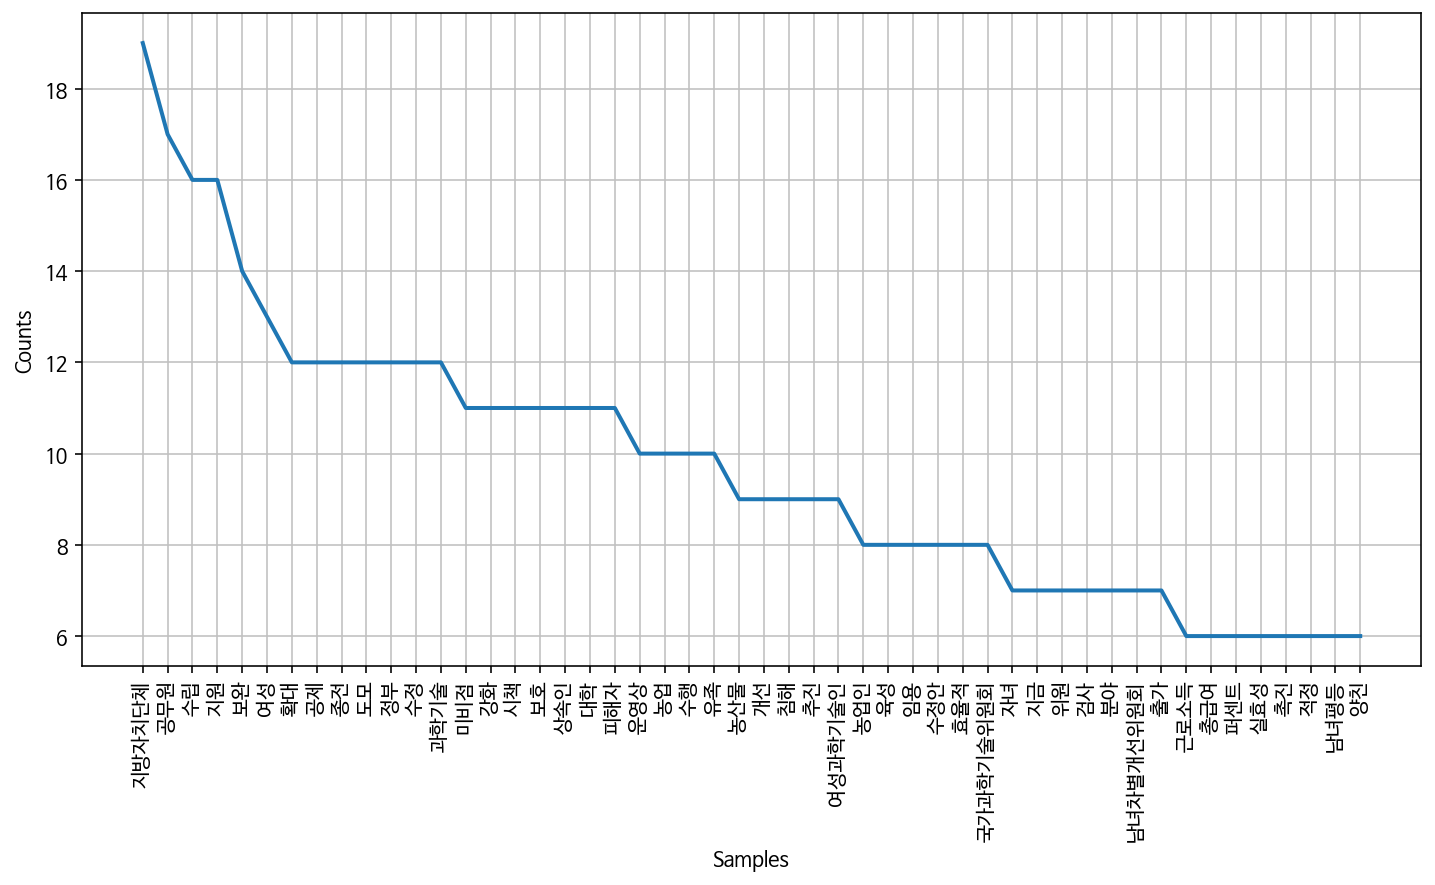

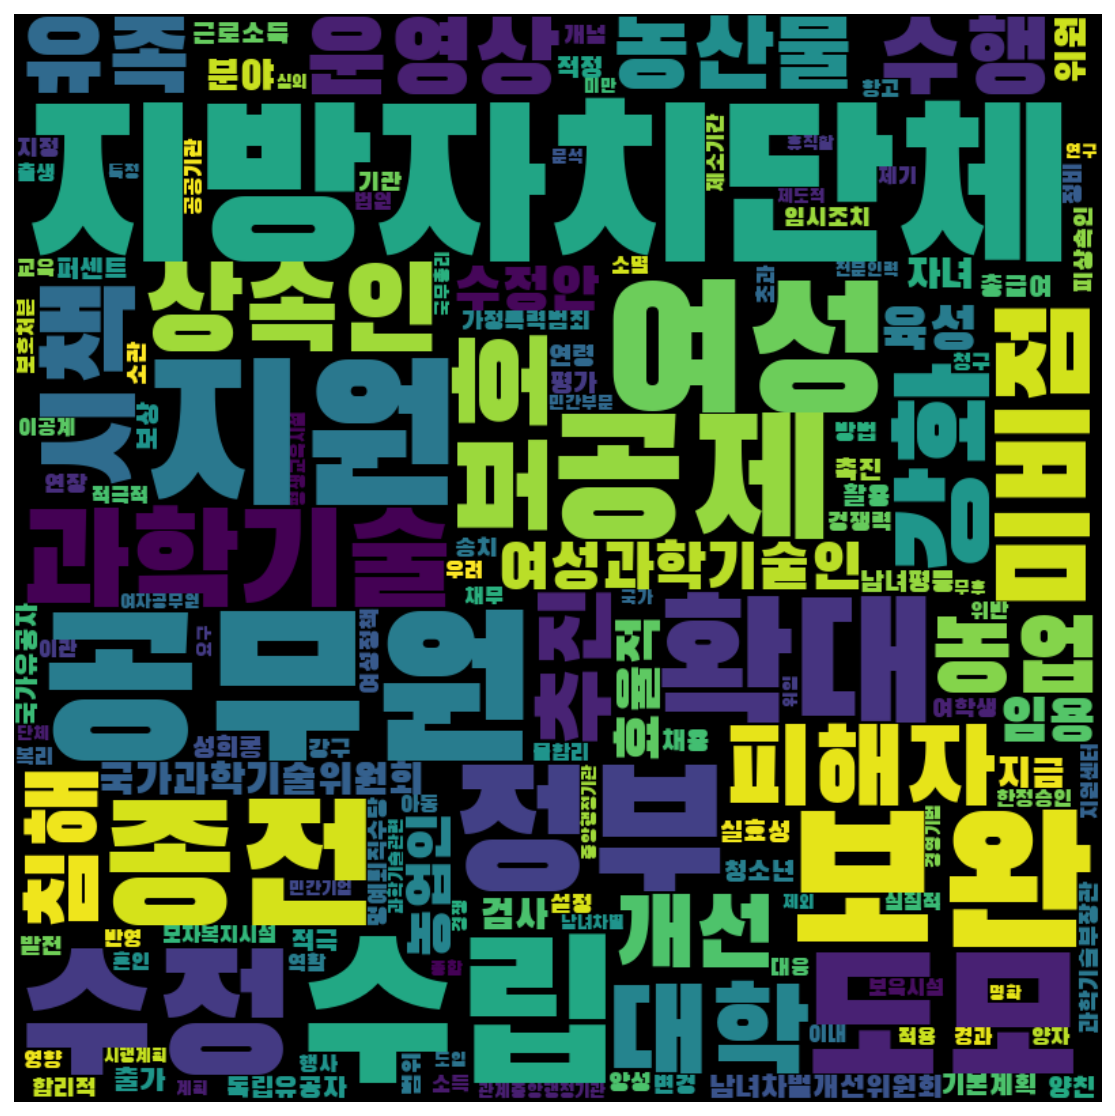

In [123]:
frewords_vis(government_word)
wordcloud_vis(government_word)

## 노무현 정권  
- 2003.02.25 ~ 2004.04.14

In [192]:
romoohyun = gender[(gender['제안일자'] > datetime.date(2003,2,25)) & 
                        (gender['제안일자'] < datetime.date(2008,2,24))]
romoohyun.shape

(454, 19)

In [193]:
romoohyun['제안자구분'].value_counts()

의원     347
위원장     55
정부      52
Name: 제안자구분, dtype: int64

In [194]:
government = romoohyun[romoohyun['제안자구분'] == '정부']
government.shape

(52, 19)

In [195]:
government

의안번호                              의안명        제안일자 제안자구분        의결일자  \
2    163106                      정부조직법중개정법률안  2004-01-20    정부  2004-03-02   
10   162903                       소년원법중개정법률안  2003-11-08    정부  2003-12-30   
11   162889                     청소년보호법중개정법률안  2003-11-07    정부  2003-12-29   
12   162872                         민법중개정법률안  2003-11-06    정부  2004-05-29   
14   162826                      정부조직법중개정법률안  2003-10-30    정부  2003-12-30   
17   162739         가정폭력방지및피해자보호등에관한법률중개정법률안  2003-10-14    정부  2003-12-18   
20   162685                       소득세법중개정법률안  2003-09-30    정부  2003-12-18   
32   162486                       군인사법중개정법률안  2003-07-28    정부  2003-12-23   
29   178002                           차별금지법안  2007-12-12    정부  2008-05-29   
32   177949                    치료감호법 일부개정법률안  2007-11-26    정부  2008-05-22   
47   177845                    모자보건법 일부개정법률안  2007-11-20    정부  2008-05-29   
50   177687                     인권교육에 관한 법률안  2007-11-02    정부  2008-05-29   
53   177528                     소득세법 일부개정법률안  2007-10-02    정부  2007-12-28   
55   177471        특수임무수행자 지원에 관한 법률 일부개정법률안  2007-09-21    정부  2008-02-26   
57   177418                  남녀고용평등법 일부개정법률안  2007-09-17    정부  2007-11-23   
64   177239   국가유공자 등 예우 및 지원에 관한 법률 일부개정법률안  2007-08-24    정부  2008-02-26   
65   177238       5·18민주유공자예우에 관한 법률 일부개정법률안  2007-08-24    정부  2008-02-26   
71   177064                    군인보수법 일부개정법률안  2007-07-09    정부  2007-12-28   
97   176854                   청소년보호법 일부개정법률안  2007-06-13    정부  2008-05-29   
99   176797                  여성발전기본법 일부개정법률안  2007-06-08    정부  2008-05-22   
100  176796  가정폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안  2007-06-08    정부  2007-09-20   
101  176795                  모·부자복지법 일부개정법률안  2007-06-08    정부  2007-09-20   
102  176794                   영유아보육법 일부개정법률안  2007-06-08    정부  2007-09-20   
157  176010          청소년의 성보호에 관한 법률 전부개정법률안  2007-01-30    정부  2007-07-02   
180  175370                   청소년보호법 일부개정법률안  2006-11-14    정부  2008-05-29   
181  175283                       민법 일부개정법률안  2006-11-07    정부  2008-05-29   
183  175185                    정부조직법 일부개정법률안  2006-10-20    정부  2008-05-29   
184  175166                   국가공무원법 일부개정법률안  2006-10-18    정부  2007-03-06   
189  175091                  조세특례제한법 일부개정법률안  2006-09-29    정부  2006-12-22   
205  174668         유전자감식정보의 수집 및 관리에 관한 법률안  2006-08-01    정부  2008-05-29   
208  174616         가정폭력범죄의처벌등에관한특례법 일부개정법률안  2006-07-19    정부  2007-04-27   
221  174308                      행형법 전부개정법률안  2006-04-26    정부  2007-11-23   
244  174003            국적 및 가족관계의 등록에 관한 법률안  2006-03-03    정부  2007-04-27   
255  173792                    직업안정법 일부개정법률안  2006-01-18    정부  2006-11-09   
260  173675                      군형법 일부개정법률안  2005-12-26    정부  2008-05-29   
261  173669                   교육공무원법 일부개정법률안  2005-12-26    정부  2008-02-19   
262  173668                    사립학교법 일부개정법률안  2005-12-26    정부  2008-02-19   
276  173233             청소년의성보호에관한법률 일부개정법률안  2005-11-07    정부  2005-12-08   
277  173232                   청소년보호법 일부개정법률안  2005-11-07    정부  2005-12-08   
280  173186                  여성발전기본법 일부개정법률안  2005-11-02    정부  2005-12-08   
281  173178                  남녀고용평등법 일부개정법률안  2005-11-02    정부  2005-12-08   
282  173177                  고용정책기본법 일부개정법률안  2005-11-02    정부  2005-12-08   
290  172878                    고용보험법 일부개정법률안  2005-10-06    정부  2005-11-16   
302  172440       가정폭력방지및피해자보호등에관한법률 일부개정법률안  2005-08-22    정부  2006-04-06   
348  171611                    모자보건법 일부개정법률안  2005-04-08    정부  2005-11-16   
366  171379                 국가인권위원회법 일부개정법률안  2005-02-17    정부  2005-06-29   
372  171339             남녀차별금지및구제에관한법률 폐지법률안  2005-02-03    정부  2005-03-02   
373  171337                    정부조직법 일부개정법률안  2005-02-03    정부  2005-03-02   
391  170756                     고령화및인구대책기본법안  2004-11-08    정부  2005-04-26   
397  170700                     국가공무원법중개정법률안  2004-11-02    정부  2005-03-02   
398  170689                  

In [196]:
model_government = Word2Vec(government['tokens'], size=100, window = 10, min_count=0, workers=4, iter=100, sg=1)

2020-10-14 00:01:37,236 : INFO : collecting all words and their counts
2020-10-14 00:01:37,237 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-14 00:01:37,244 : INFO : collected 3042 word types from a corpus of 10345 raw words and 52 sentences
2020-10-14 00:01:37,245 : INFO : Loading a fresh vocabulary
2020-10-14 00:01:37,253 : INFO : effective_min_count=0 retains 3042 unique words (100% of original 3042, drops 0)
2020-10-14 00:01:37,254 : INFO : effective_min_count=0 leaves 10345 word corpus (100% of original 10345, drops 0)
2020-10-14 00:01:37,265 : INFO : deleting the raw counts dictionary of 3042 items
2020-10-14 00:01:37,266 : INFO : sample=0.001 downsamples 35 most-common words
2020-10-14 00:01:37,266 : INFO : downsampling leaves estimated 9878 word corpus (95.5% of prior 10345)
2020-10-14 00:01:37,273 : INFO : estimated required memory for 3042 words and 100 dimensions: 3954600 bytes
2020-10-14 00:01:37,274 : INFO : resetting layer weights
2020

2020-10-14 00:01:39,500 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:01:39,583 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:01:39,584 : INFO : EPOCH - 15 : training on 10345 raw words (9901 effective words) took 0.1s, 109674 effective words/s
2020-10-14 00:01:39,590 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:01:39,594 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:01:39,599 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:01:39,673 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:01:39,674 : INFO : EPOCH - 16 : training on 10345 raw words (9862 effective words) took 0.1s, 118254 effective words/s
2020-10-14 00:01:39,678 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:01:39,680 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-1

2020-10-14 00:01:41,100 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:01:41,106 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:01:41,110 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:01:41,178 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:01:41,178 : INFO : EPOCH - 32 : training on 10345 raw words (9867 effective words) took 0.1s, 126342 effective words/s
2020-10-14 00:01:41,185 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:01:41,194 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:01:41,195 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:01:41,270 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:01:41,270 : INFO : EPOCH - 33 : training on 10345 raw words (9881 effective words) took 0.1s, 113252 effective words/s
2020-1

2020-10-14 00:01:42,641 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:01:42,642 : INFO : EPOCH - 48 : training on 10345 raw words (9855 effective words) took 0.1s, 119539 effective words/s
2020-10-14 00:01:42,648 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:01:42,651 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:01:42,654 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:01:42,728 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:01:42,730 : INFO : EPOCH - 49 : training on 10345 raw words (9875 effective words) took 0.1s, 115965 effective words/s
2020-10-14 00:01:42,737 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:01:42,738 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:01:42,742 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-1

2020-10-14 00:01:44,034 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:01:44,039 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:01:44,098 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:01:44,099 : INFO : EPOCH - 65 : training on 10345 raw words (9841 effective words) took 0.1s, 130997 effective words/s
2020-10-14 00:01:44,104 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:01:44,112 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:01:44,114 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:01:44,181 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:01:44,184 : INFO : EPOCH - 66 : training on 10345 raw words (9865 effective words) took 0.1s, 123025 effective words/s
2020-10-14 00:01:44,195 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-1

2020-10-14 00:01:45,559 : INFO : EPOCH - 81 : training on 10345 raw words (9880 effective words) took 0.1s, 112799 effective words/s
2020-10-14 00:01:45,564 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:01:45,567 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:01:45,571 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:01:45,648 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:01:45,649 : INFO : EPOCH - 82 : training on 10345 raw words (9858 effective words) took 0.1s, 116074 effective words/s
2020-10-14 00:01:45,656 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:01:45,659 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:01:45,662 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:01:45,731 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-1

2020-10-14 00:01:46,898 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:01:46,968 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:01:46,969 : INFO : EPOCH - 98 : training on 10345 raw words (9862 effective words) took 0.1s, 129147 effective words/s
2020-10-14 00:01:46,975 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:01:46,985 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:01:46,986 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:01:47,046 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:01:47,046 : INFO : EPOCH - 99 : training on 10345 raw words (9867 effective words) took 0.1s, 138000 effective words/s
2020-10-14 00:01:47,055 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:01:47,057 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-1

In [197]:
print(model_government.wv.most_similar('여성'))

2020-10-14 00:01:47,137 : INFO : precomputing L2-norms of word weight vectors


[('재혼금지기간', 0.6242648363113403), ('차별적', 0.61545729637146), ('충돌', 0.613132119178772), ('친자관계감정기법', 0.5900853872299194), ('부성추정', 0.5894635915756226), ('발달', 0.5797392129898071), ('우대', 0.57445228099823), ('여성발전', 0.5722219944000244), ('보육급여', 0.5540395975112915), ('소득세법중개정법률', 0.5523256063461304)]


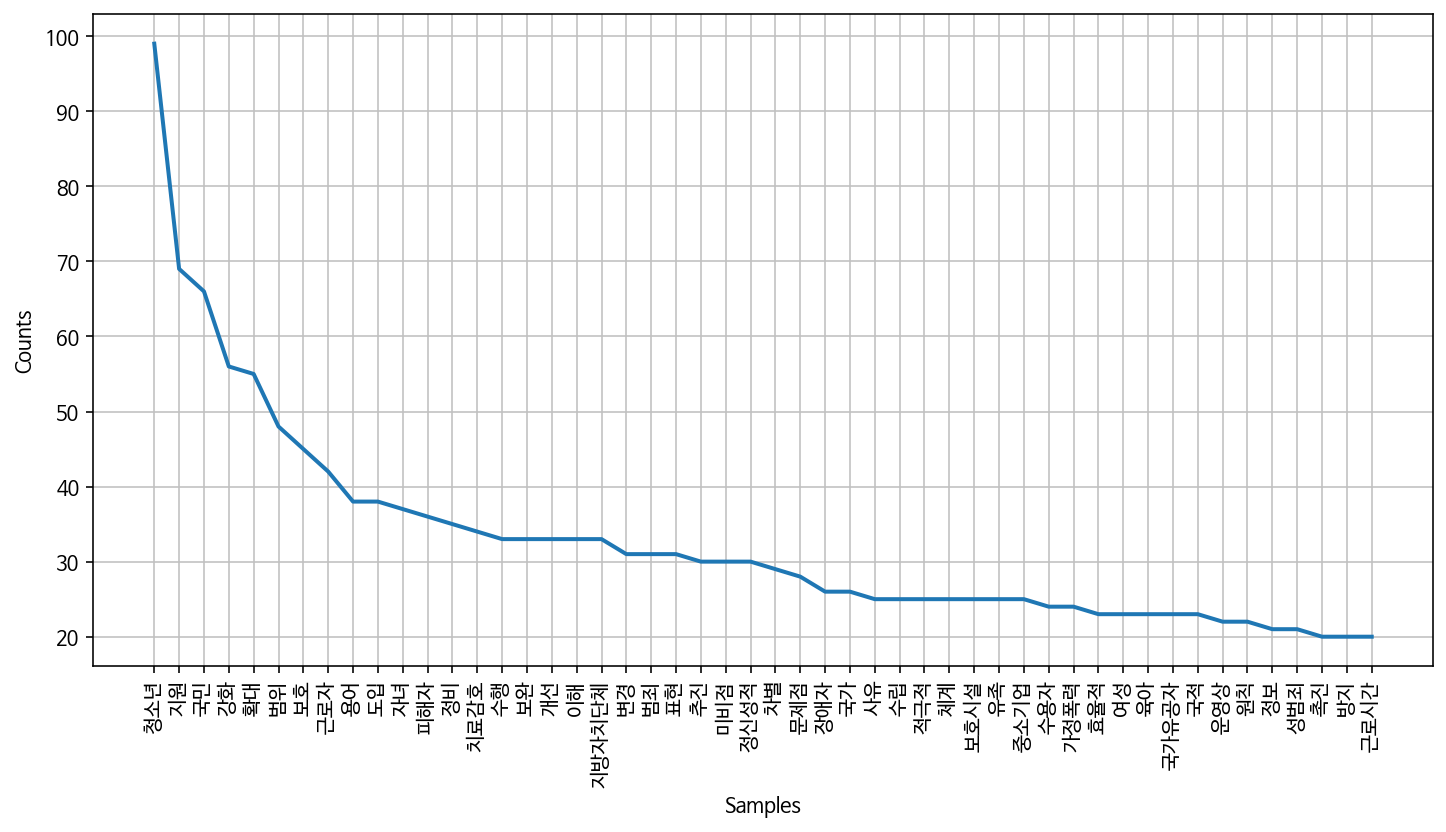

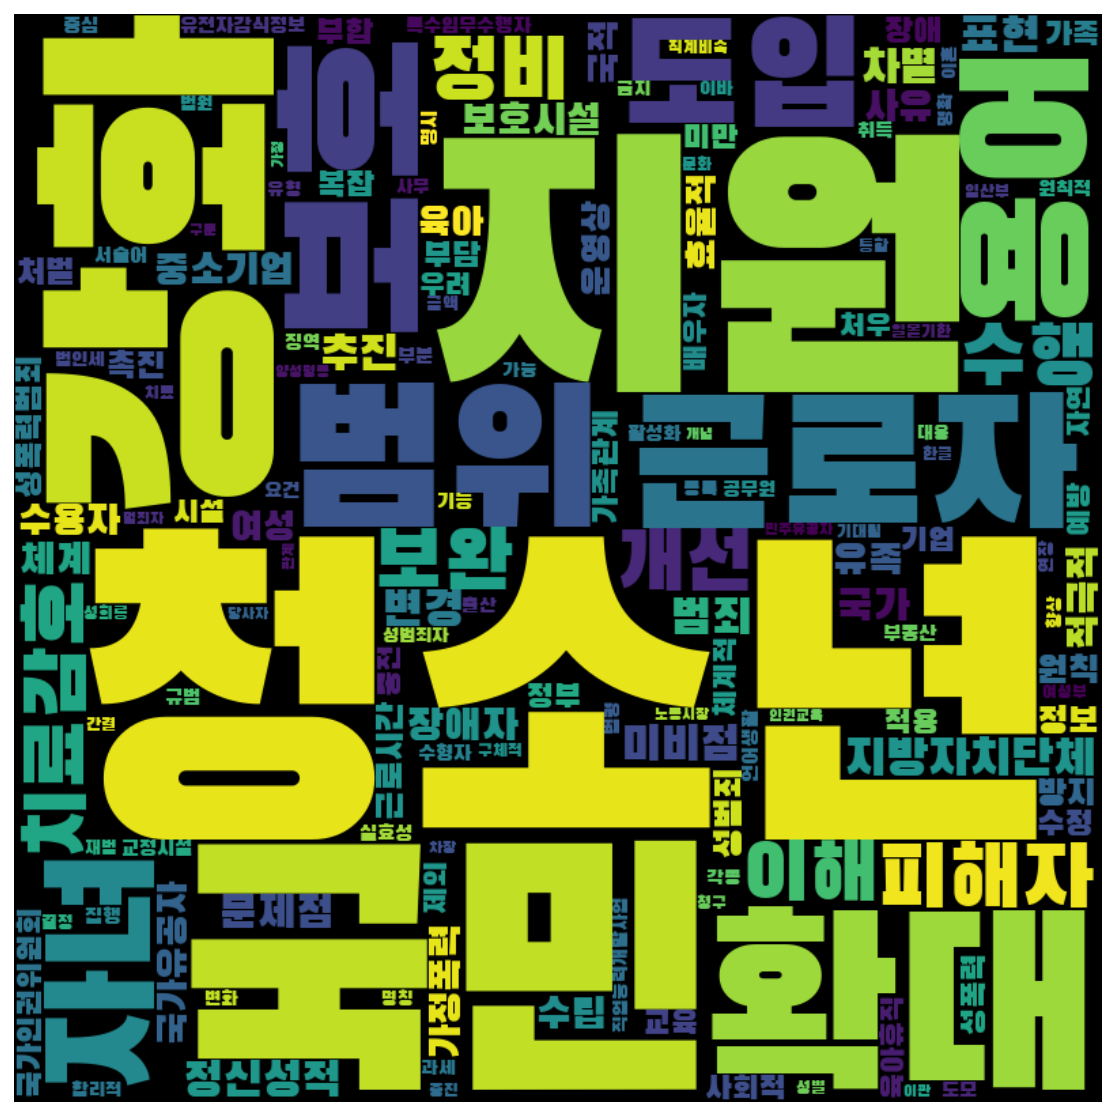

In [130]:
government_word = total_tokens(government['tokens'])

stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출','신설','한편','문제','지급','제공','항제','사용','근거','대상',
            '이유','증가','제도','사업','정책','우리나라','행위','특례법','불구','수준','추가','관리','확보','의무','업무','문장']
government_word = [each_word for each_word in government_word if each_word not in stopwords]

frewords_vis(government_word)
wordcloud_vis(government_word)

## 이명박 정권
- 2008.02.25 ~ 2013.02.24

In [198]:
leemyungbak = gender[(gender['제안일자'] > datetime.date(2008,2,25)) & 
                        (gender['제안일자'] < datetime.date(2013,2,24))]
leemyungbak.shape

(1131, 19)

In [199]:
leemyungbak['제안자구분'].value_counts()

의원     1002
위원장      84
정부       45
Name: 제안자구분, dtype: int64

In [200]:
government = leemyungbak[leemyungbak['제안자구분'] == '정부']
government.shape

(45, 19)

In [201]:
government

의안번호                                                의안명        제안일자  \
5     178344                 성폭력범죄의 처벌 및 피해자보호 등에 관한 법률 일부개정법률안  2008-05-08   
10   1814504           특정 범죄자에 대한 위치추적 전자장치 부착 등에 관한 법률 일부개정법률안  2012-01-06   
37   1814286                  남녀고용평등과 일·가정 양립 지원에 관한 법률 일부개정법률안  2011-12-28   
42   1814177                   범죄수익은닉의 규제 및 처벌 등에 관한 법률 일부개정법률안  2011-12-14   
65   1813679                        성폭력범죄의 처벌 등에 관한 특례법 일부개정법률안  2011-10-28   
72   1813616                                         형법 일부개정법률안  2011-10-25   
108  1813177                                      근로기준법 일부개정법률안  2011-09-09   
109  1813175                  남녀고용평등과 일·가정 양립 지원에 관한 법률 일부개정법률안  2011-09-09   
117  1813018                                   한부모가족지원법 일부개정법률안  2011-08-26   
168  1811832          농어업인 삶의 질 향상 및 농어촌지역 개발촉진에 관한 특별법 일부개정법률안  2011-05-17   
211  1811304                                         형법 일부개정법률안  2011-03-25   
218  1811223                    가족친화 사회환경의 조성 촉진에 관한 법률 일부개정법률안  2011-03-18   
249  1810790                                     장애인복지법 일부개정법률안  2011-02-11   
283  1810250                                     청소년보호법 전부개정법률안  2010-12-09   
306  1809936                                   장애인활동 지원에 관한 법률안  2010-11-17   
316  1809854                                    여성발전기본법 전부개정법률안  2010-11-09   
317  1809838                                      고용보험법 일부개정법률안  2010-11-08   
336  1809534                                    조세특례제한법 일부개정법률안  2010-10-01   
411  1808851                                     국가공무원법 일부개정법률안  2010-07-14   
412  1808850                                     지방공무원법 일부개정법률안  2010-07-14   
426  1808750                       가정폭력범죄의 처벌 등에 관한 특례법 일부개정법률안  2010-06-30   
539  1807637                 성폭력범죄의 처벌 및 피해자보호 등에 관한 법률 일부개정법률안  2010-02-18   
576  1807199           특정 범죄자에 대한 위치추적 전자장치 부착 등에 관한 법률 일부개정법률안  2009-12-29   
599  1806833                                   한부모가족지원법 일부개정법률안  2009-12-03   
633  1806034                 성폭력범죄의 처벌 및 피해자보호 등에 관한 법률 전부개정법률안  2009-09-15   
634  1806032                            성폭력방지 및 피해자보호 등에 관한 법률안  2009-09-15   
637  1805989                고용상 연령차별금지 및 고령자고용촉진에 관한 법률 일부개정법률안  2009-09-11   
658  1805585                                 여성농어업인 육성법 일부개정법률안  2009-07-29   
659  1805580                              여성기업지원에 관한 법률 일부개정법률안  2009-07-29   
660  1805569                          여성과학기술인육성및지원에관한법률 일부개정법률안  2009-07-29   
662  1805508                         특정강력범죄의 처벌에 관한 특례법 일부개정법률안  2009-07-21   
746  1803491                    가정폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안  2009-01-12   
755  1802213                            청소년의 성보호에 관한 법률 전부개정법률안  2008-11-24   
766  1801928                            장애인고용촉진 및 직업재활법 일부개정법률안  2008-11-12   
767  1801874                                      고용보험법 일부개정법률안  2008-11-11   
783  1800899  일제하 일본군위안부 피해자에 대한 생활안정지원 및 기념사업 등에 관한 법률 일부개정법률안  2008-09-10   
789  1800848                                      모자보건법 일부개정법률안  2008-09-04   
783  1903117                                      사립학교법 일부개정법률안  2012-12-21   
784  1903116                                     교육공무원법 일부개정법률안  2012-12-21   
829  1902680                   범죄수익은닉의 규제 및 처벌 등에 관한 법률 일부개정법률안  2012-11-20   
875  1902018                     성폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안  2012-09-27   
877  1901985                           결혼중개업의 관리에 관한 법률 일부개정법률안  2012-09-26   
879  1901982                                      형사소송법 일부개정법률안  2012-09-26   
979  1901143                                         형법 일부개정법률안  2012-08-13   
993  1900955                        성폭력범죄의 처벌 등에 관한 특례법 일부개정법률안  2012-07-31   

    제안자구분        의결일자    의결결과                    제안회기  \
5      정부  2008-05-22  대안반영폐기  제17대 (2004~2008) 제273회   
10     정부  2012-05-29  임기만료폐기  제18대 (2008~2012) 제304회   
37     정부  2012-05-29  임기만료폐기  제18대 (2008~2012) 제304회   
42     정부  2012-05-29  임기만료폐기  제18대 (2008~2012) 제303회   
65     정부  2012-05-29  임기만료폐기  제18대 (2008~2012) 제303회   
72     정부  2012-05-29  임기만료폐기  

In [202]:
model_government = Word2Vec(government['tokens'], size=100, window = 10, min_count=0, workers=4, iter=100, sg=1)




2020-10-14 00:02:24,450 : INFO : collecting all words and their counts
2020-10-14 00:02:24,453 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-14 00:02:24,457 : INFO : collected 1870 word types from a corpus of 6525 raw words and 45 sentences
2020-10-14 00:02:24,459 : INFO : Loading a fresh vocabulary
2020-10-14 00:02:24,465 : INFO : effective_min_count=0 retains 1870 unique words (100% of original 1870, drops 0)
2020-10-14 00:02:24,467 : INFO : effective_min_count=0 leaves 6525 word corpus (100% of original 6525, drops 0)
2020-10-14 00:02:24,475 : INFO : deleting the raw counts dictionary of 1870 items
2020-10-14 00:02:24,476 : INFO : sample=0.001 downsamples 49 most-common words
2020-10-14 00:02:24,478 : INFO : downsampling leaves estimated 6104 word corpus (93.6% of prior 6525)
2020-10-14 00:02:24,484 : INFO : estimated required memory for 1870 words and 100 dimensions: 2431000 bytes
2020-10-14 00:02:24,485 : INFO : resetting layer weights
2020-10-

2020-10-14 00:02:25,876 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:25,933 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:25,934 : INFO : EPOCH - 15 : training on 6525 raw words (6130 effective words) took 0.1s, 97138 effective words/s
2020-10-14 00:02:25,940 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:25,942 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:25,943 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:25,998 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:25,999 : INFO : EPOCH - 16 : training on 6525 raw words (6096 effective words) took 0.1s, 102952 effective words/s
2020-10-14 00:02:26,005 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:26,006 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-1

2020-10-14 00:02:26,900 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:26,902 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:26,903 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:26,946 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:26,947 : INFO : EPOCH - 32 : training on 6525 raw words (6092 effective words) took 0.0s, 131096 effective words/s
2020-10-14 00:02:26,951 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:26,953 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:26,953 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:26,998 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:26,999 : INFO : EPOCH - 33 : training on 6525 raw words (6123 effective words) took 0.0s, 127260 effective words/s
2020-10-

2020-10-14 00:02:27,822 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:27,823 : INFO : EPOCH - 48 : training on 6525 raw words (6097 effective words) took 0.1s, 120282 effective words/s
2020-10-14 00:02:27,828 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:27,829 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:27,829 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:27,875 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:27,876 : INFO : EPOCH - 49 : training on 6525 raw words (6127 effective words) took 0.1s, 120409 effective words/s
2020-10-14 00:02:27,881 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:27,883 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:27,883 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-

2020-10-14 00:02:28,700 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:28,700 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:28,744 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:28,745 : INFO : EPOCH - 65 : training on 6525 raw words (6102 effective words) took 0.0s, 130942 effective words/s
2020-10-14 00:02:28,750 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:28,753 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:28,753 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:28,796 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:28,796 : INFO : EPOCH - 66 : training on 6525 raw words (6102 effective words) took 0.0s, 131764 effective words/s
2020-10-14 00:02:28,801 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-

2020-10-14 00:02:29,598 : INFO : EPOCH - 81 : training on 6525 raw words (6116 effective words) took 0.0s, 134553 effective words/s
2020-10-14 00:02:29,604 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:29,605 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:29,606 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:29,649 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:29,650 : INFO : EPOCH - 82 : training on 6525 raw words (6110 effective words) took 0.0s, 132405 effective words/s
2020-10-14 00:02:29,655 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:29,657 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:29,658 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:29,703 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-

2020-10-14 00:02:30,419 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:30,461 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:30,462 : INFO : EPOCH - 98 : training on 6525 raw words (6118 effective words) took 0.0s, 128348 effective words/s
2020-10-14 00:02:30,468 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:30,469 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:30,470 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:30,511 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:30,512 : INFO : EPOCH - 99 : training on 6525 raw words (6113 effective words) took 0.0s, 140517 effective words/s
2020-10-14 00:02:30,517 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:30,518 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-

In [203]:
print(model_government.wv.most_similar('여성'))

2020-10-14 00:02:30,569 : INFO : precomputing L2-norms of word weight vectors


[('대표성', 0.7418712377548218), ('공직', 0.7237347960472107), ('균형', 0.7223106622695923), ('편성', 0.7212812900543213), ('결산', 0.7211914658546448), ('정치', 0.7183761596679688), ('성별', 0.7154934406280518), ('동등', 0.7119355201721191), ('검토', 0.7100170850753784), ('성평등지수', 0.7087364792823792)]


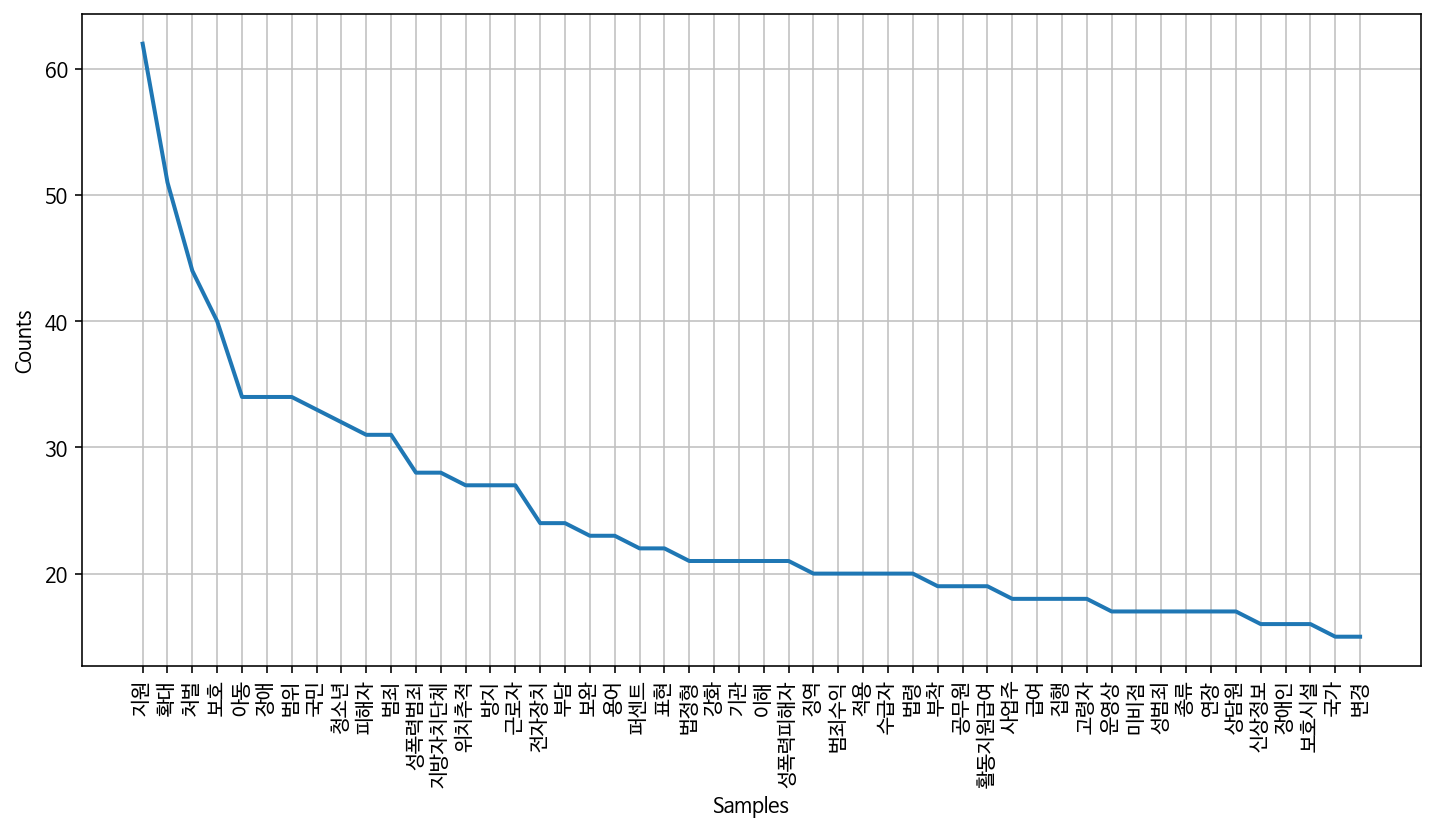

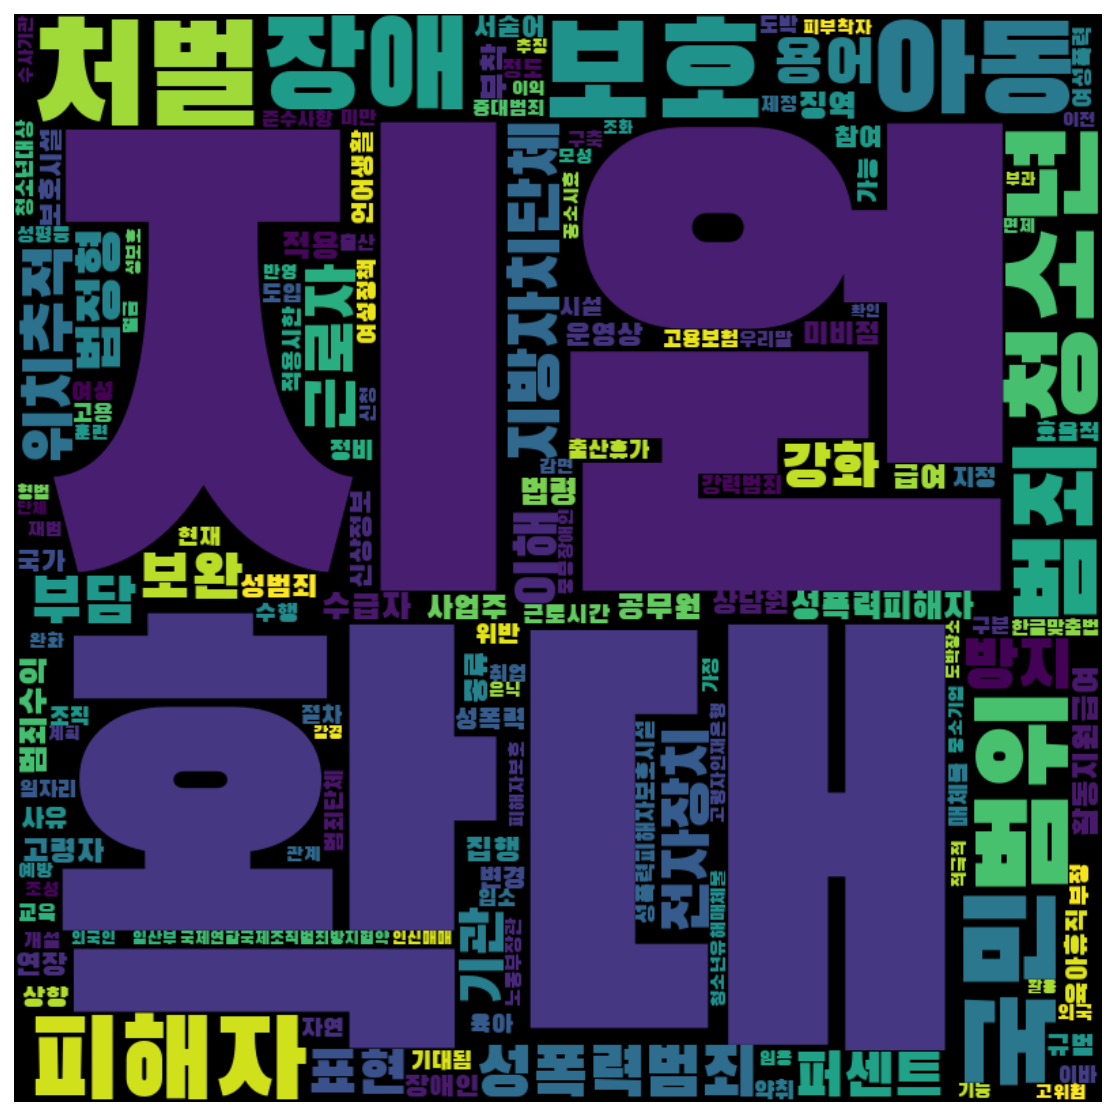

In [137]:
government_word = total_tokens(government['tokens'])

stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출','신설','한편','문제','지급','제공','항제','사용','근거','대상',
            '이유','증가','제도','사업','정책','우리나라','행위','특례법','불구','수준','추가','관리','확보','의무','업무','문장']
government_word = [each_word for each_word in government_word if each_word not in stopwords]

frewords_vis(government_word)
wordcloud_vis(government_word)

## 박근혜 정권
- 2013.02.25 ~ 2017.03.13

In [204]:
parkkeunhye = gender[(gender['제안일자'] > datetime.date(2013,2,25)) & 
                        (gender['제안일자'] < datetime.date(2017,5,10))]
parkkeunhye.shape

(1121, 19)

In [205]:
parkkeunhye['제안자구분'].value_counts()

의원     1022
위원장      67
정부       32
Name: 제안자구분, dtype: int64

In [206]:
government = parkkeunhye[parkkeunhye['제안자구분'] == '정부']
government.shape

(32, 19)

In [207]:
model_government = Word2Vec(government['tokens'], size=100, window = 10, min_count=0, workers=4, iter=100, sg=1)

2020-10-14 00:02:58,085 : INFO : collecting all words and their counts
2020-10-14 00:02:58,087 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-14 00:02:58,091 : INFO : collected 1065 word types from a corpus of 3306 raw words and 32 sentences
2020-10-14 00:02:58,092 : INFO : Loading a fresh vocabulary
2020-10-14 00:02:58,098 : INFO : effective_min_count=0 retains 1065 unique words (100% of original 1065, drops 0)
2020-10-14 00:02:58,099 : INFO : effective_min_count=0 leaves 3306 word corpus (100% of original 3306, drops 0)
2020-10-14 00:02:58,104 : INFO : deleting the raw counts dictionary of 1065 items
2020-10-14 00:02:58,106 : INFO : sample=0.001 downsamples 78 most-common words
2020-10-14 00:02:58,107 : INFO : downsampling leaves estimated 2900 word corpus (87.7% of prior 3306)
2020-10-14 00:02:58,111 : INFO : estimated required memory for 1065 words and 100 dimensions: 1384500 bytes
2020-10-14 00:02:58,115 : INFO : resetting layer weights
2020-10-

2020-10-14 00:02:58,915 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:58,940 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:58,940 : INFO : EPOCH - 15 : training on 3306 raw words (2887 effective words) took 0.0s, 94776 effective words/s
2020-10-14 00:02:58,947 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:58,949 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:58,951 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:58,969 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:58,970 : INFO : EPOCH - 16 : training on 3306 raw words (2894 effective words) took 0.0s, 123967 effective words/s
2020-10-14 00:02:58,976 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:58,978 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-1

2020-10-14 00:02:59,446 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:59,448 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:59,450 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:59,471 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:59,473 : INFO : EPOCH - 32 : training on 3306 raw words (2890 effective words) took 0.0s, 96222 effective words/s
2020-10-14 00:02:59,481 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:59,482 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:59,487 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:02:59,506 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:59,507 : INFO : EPOCH - 33 : training on 3306 raw words (2905 effective words) took 0.0s, 100443 effective words/s
2020-10-1

2020-10-14 00:02:59,973 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:02:59,973 : INFO : EPOCH - 48 : training on 3306 raw words (2897 effective words) took 0.0s, 107663 effective words/s
2020-10-14 00:02:59,978 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:02:59,980 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:02:59,982 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:00,001 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:00,003 : INFO : EPOCH - 49 : training on 3306 raw words (2877 effective words) took 0.0s, 107398 effective words/s
2020-10-14 00:03:00,008 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:00,010 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:00,011 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-

2020-10-14 00:03:00,470 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:00,471 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:00,489 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:00,490 : INFO : EPOCH - 65 : training on 3306 raw words (2894 effective words) took 0.0s, 114655 effective words/s
2020-10-14 00:03:00,497 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:00,501 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:00,502 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:00,522 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:00,524 : INFO : EPOCH - 66 : training on 3306 raw words (2891 effective words) took 0.0s, 109193 effective words/s
2020-10-14 00:03:00,530 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-

2020-10-14 00:03:00,979 : INFO : EPOCH - 81 : training on 3306 raw words (2896 effective words) took 0.0s, 119369 effective words/s
2020-10-14 00:03:00,983 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:00,985 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:00,987 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:01,006 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:01,008 : INFO : EPOCH - 82 : training on 3306 raw words (2899 effective words) took 0.0s, 117213 effective words/s
2020-10-14 00:03:01,012 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:01,015 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:01,018 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:01,037 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-

2020-10-14 00:03:01,443 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:01,458 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:01,459 : INFO : EPOCH - 98 : training on 3306 raw words (2919 effective words) took 0.0s, 128990 effective words/s
2020-10-14 00:03:01,463 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:01,464 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:01,467 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:01,484 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:01,485 : INFO : EPOCH - 99 : training on 3306 raw words (2897 effective words) took 0.0s, 130462 effective words/s
2020-10-14 00:03:01,489 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:01,491 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-

In [208]:
print(model_government.wv.most_similar('여성'))

2020-10-14 00:03:01,520 : INFO : precomputing L2-norms of word weight vectors


[('활용도', 0.8026244044303894), ('학생군사', 0.802013635635376), ('남성', 0.8018251657485962), ('학생군사교육단', 0.7983275651931763), ('인력', 0.7957373261451721), ('합격', 0.7944062948226929), ('교육단', 0.7938545942306519), ('숙련', 0.7918809652328491), ('장기복무', 0.78993821144104), ('단기복무', 0.789060115814209)]


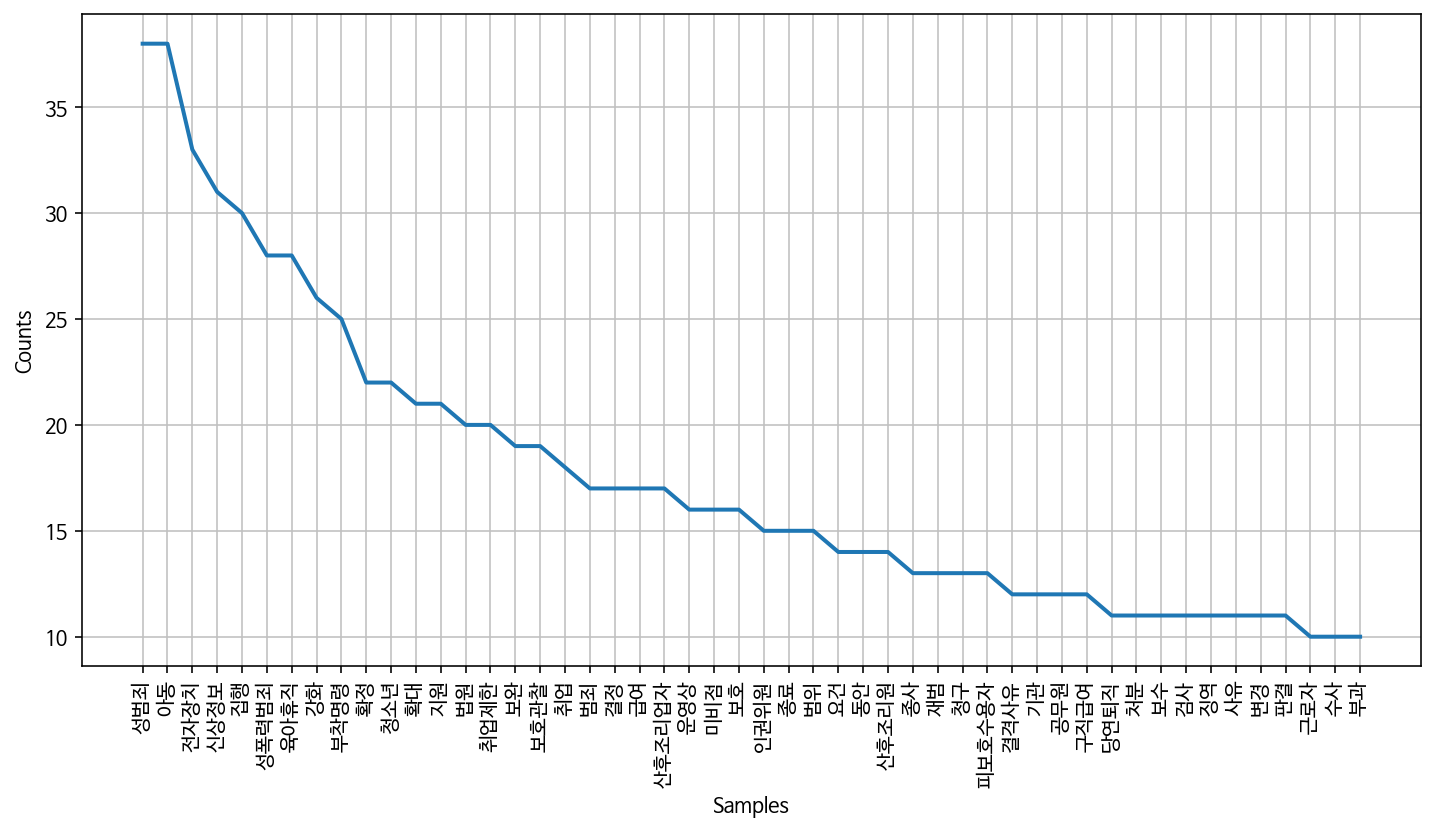

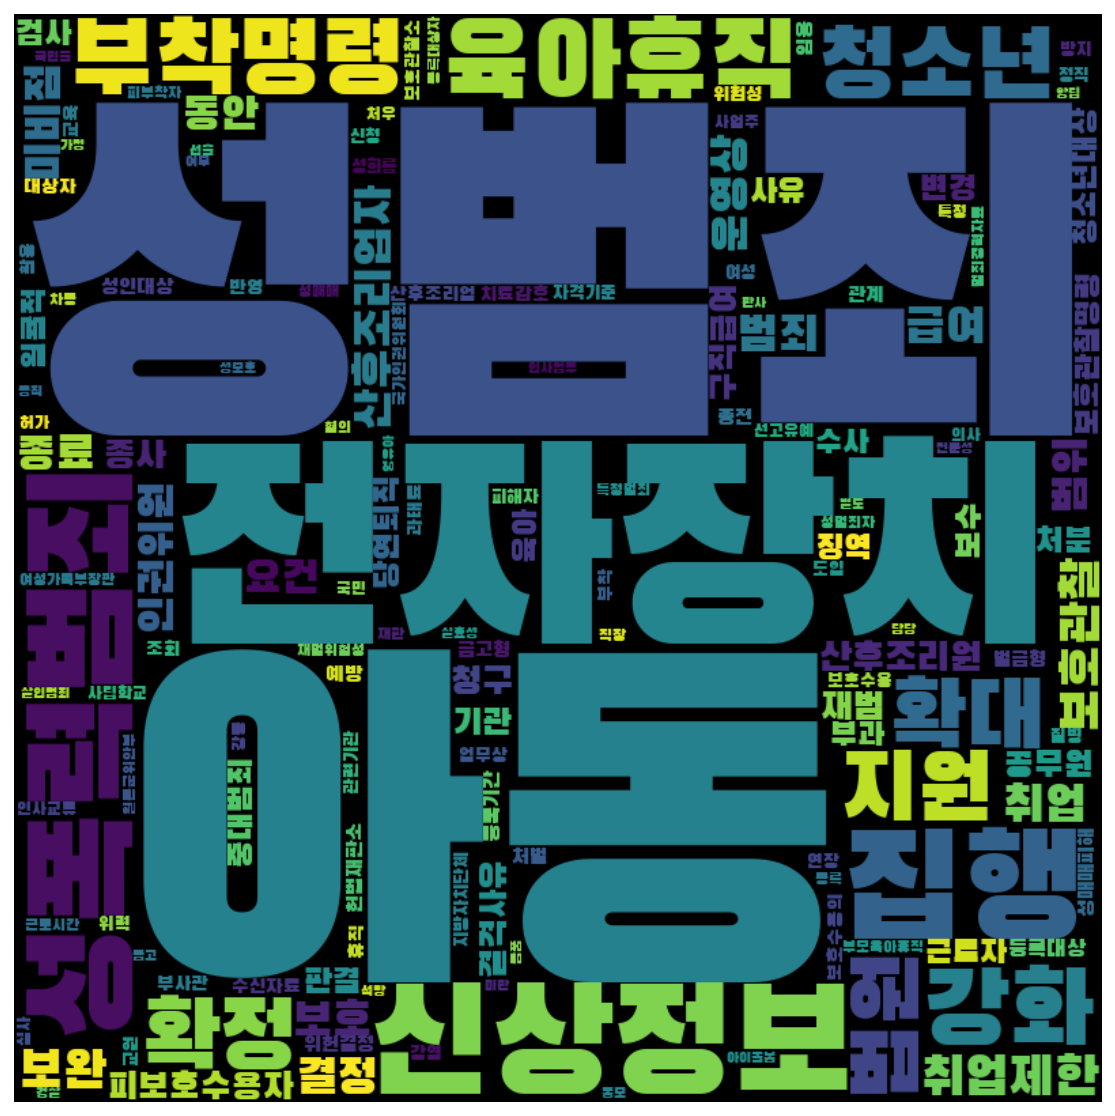

In [143]:
government_word = total_tokens(government['tokens'])

stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출','신설','한편','문제','지급','제공','항제','사용','근거','대상',
            '이유','증가','제도','사업','정책','우리나라','행위','특례법','불구','수준','추가','관리','확보','의무','업무','문장']
government_word = [each_word for each_word in government_word if each_word not in stopwords]

frewords_vis(government_word)
wordcloud_vis(government_word)

## 문재인 정권 
- 2017.05.10 ~

In [209]:
moonjaein = gender[(gender['제안일자'] > datetime.date(2017,5,10))]
moonjaein.shape

(1410, 19)

In [210]:
moonjaein['제안자구분'].value_counts()

의원     1286
위원장     102
정부       22
Name: 제안자구분, dtype: int64

In [211]:
government = moonjaein[moonjaein['제안자구분'] == '정부']
government.shape

(22, 19)

In [212]:
government

의안번호                                              의안명        제안일자  \
53    2024627                                     군인사법 일부개정법률안  2020-02-21   
77    2024266                                   새마을금고법 일부개정법률안  2019-12-13   
81    2024208                  가정폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안  2019-12-06   
266   2021090                                   지방공무원법 일부개정법률안  2019-06-21   
369   2020002                             2019년도 양성평등기금운용계획변경안  2019-04-25   
442   2019222                      성폭력범죄의 처벌 등에 관한 특례법 일부개정법률안  2019-03-15   
547   2017665                                   군무원인사법 일부개정법률안  2018-12-21   
618   2016649                           산림복지 진흥에 관한 법률 일부개정법률안  2018-11-16   
620   2016639                  가족친화 사회환경의 조성 촉진에 관한 법률 일부개정법률안  2018-11-16   
735   2014822  군사정전에 관한 협정 체결 이후 납북피해자의 보상 및 지원에 관한 법률 일부개정법률안  2018-08-09   
748   2014647                                 한부모가족지원법 일부개정법률안  2018-07-31   
799   2013902                                공익신고자 보호법 일부개정법률안  2018-06-08   
998   2012268                                    가사소송법 전부개정법률안  2018-03-02   
1099  2011253                         결혼중개업의 관리에 관한 법률 일부개정법률안  2018-01-03   
1100  2011240                                   영유아보육법 일부개정법률안  2018-01-03   
1107  2011124                                   교육공무원법 일부개정법률안  2017-12-29   
1111  2011076                            가사근로자의 고용개선 등에 관한 법률안  2017-12-28   
1187  2010003                                  양성평등기본법 일부개정법률안  2017-11-03   
1261  2008733                   성폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안  2017-08-28   
1262  2008732                   성매매방지 및 피해자보호 등에 관한 법률 일부개정법률안  2017-08-28   
1263  2008730                  가정폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안  2017-08-28   
1299  2008198                  성폭력범죄자의 성충동 약물치료에 관한 법률 일부개정법률안  2017-07-26   

     제안자구분        의결일자    의결결과                    제안회기  \
53      정부  2020-05-29  임기만료폐기  제20대 (2016~2020) 제376회   
77      정부  2020-05-29  임기만료폐기  제20대 (2016~2020) 제372회   
81      정부  2020-05-29  임기만료폐기  제20대 (2016~2020) 제371회   
266     정부  2020-05-29  임기만료폐기  제20대 (2016~2020) 제369회   
369     정부  2019-08-02    원안가결  제20대 (2016~2020) 제368회   
442     정부  2020-01-09    수정가결  제20대 (2016~2020) 제367회   
547     정부  2020-05-29  임기만료폐기  제20대 (2016~2020) 제365회   
618     정부  2019-10-31    수정가결  제20대 (2016~2020) 제364회   
620     정부  2020-05-20  대안반영폐기  제20대 (2016~2020) 제364회   
735     정부  2018-12-07  대안반영폐기  제20대 (2016~2020) 제362회   
748     정부  2020-05-29  임기만료폐기  제20대 (2016~2020) 제362회   
799     정부  2020-04-29  대안반영폐기  제20대 (2016~2020) 제361회   
998     정부  2020-05-29  임기만료폐기  제20대 (2016~2020) 제356회   
1099    정부  2018-02-28    수정가결  제20대 (2016~2020) 제355회   
1100    정부  2020-05-29  임기만료폐기  제20대 (2016~2020) 제355회   
1107    정부  2018-11-29  대안반영폐기  제20대 (2016~2020) 제355회   
1111    정부  2020-05-29  임기만료폐기  제20대 (2016~2020) 제355회   
1187    정부  2018-02-20  대안반영폐기  제20대 (2016~2020) 제354회   
1261    정부  2018-02-20  대안반영폐기  제20대 (2016~2020) 제353회   
1262    정부  2018-02-20  대안반영폐기  제20대 (2016~2020) 제353회   
1263    정부  2018-02-20    수정가결  제20대 (2016~2020) 제353회   
1299    정부  2017-12-01    수정가결  제20대 (2016~2020) 제352회   

                                                   제안이유          소관위원회 제안자  \
53      ■   및  일과 가정의 양립이 가능한 공직문화 조성을 위하여 첫째 자녀에 대하...          국방위원회  []   
77      ■  자기자본의 확충을 통한 경영의 건전성을 도모하기 위하여 새마을금고와 새마을...        행정안전위원회  []   
81        및  가정폭력피해자 보호시설 또는 가정폭력 관련 상담원 교육훈련시설을 설치ㆍ...        여성가족위원회  []   
266       및  시ㆍ도의회 사무기구 인력운영의 자율성을 높이기 위하여 시ㆍ도의회의 의장...        행정안전위원회  []   
369                                                            여성가족위원회  []   
442       및  성폭력범죄를 저질러 신상정보 등록대상자가 된 사람은 신상정보 등록기간(...        법제사법위원회  []   
547      군무원이 육아휴직을 출산휴가와 연속하여 사용하는 경우에는 출산휴가일부터 후임자...          국방위원회  []   
618       및  산림복지 관련 정책결정 과정에서 양성이 평등하게 참여할 수 있도록 산림...  농림축산식품해양수산위원회  []   
620       및  여성가족부장관 및 지방자치단체의 장은 가족친화지원센터가 거짓이나 그 밖...        여성가족위원회  []   
735       및  납북피해자의 보상 및 지원에 관한 사항을 심의ㆍ의결하는 납북피해자보상및...        외교통일위원회  []   
748       및  국민생활 및 기

In [213]:
model_government = Word2Vec(government['tokens'], size=100, window = 10, min_count=0, workers=4, iter=100, sg=1)

2020-10-14 00:03:41,154 : INFO : collecting all words and their counts
2020-10-14 00:03:41,156 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-14 00:03:41,158 : INFO : collected 885 word types from a corpus of 2032 raw words and 22 sentences
2020-10-14 00:03:41,160 : INFO : Loading a fresh vocabulary
2020-10-14 00:03:41,164 : INFO : effective_min_count=0 retains 885 unique words (100% of original 885, drops 0)
2020-10-14 00:03:41,166 : INFO : effective_min_count=0 leaves 2032 word corpus (100% of original 2032, drops 0)
2020-10-14 00:03:41,171 : INFO : deleting the raw counts dictionary of 885 items
2020-10-14 00:03:41,175 : INFO : sample=0.001 downsamples 72 most-common words
2020-10-14 00:03:41,179 : INFO : downsampling leaves estimated 1802 word corpus (88.7% of prior 2032)
2020-10-14 00:03:41,184 : INFO : estimated required memory for 885 words and 100 dimensions: 1150500 bytes
2020-10-14 00:03:41,190 : INFO : resetting layer weights
2020-10-14 00

2020-10-14 00:03:41,779 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:41,791 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:41,792 : INFO : EPOCH - 15 : training on 2032 raw words (1790 effective words) took 0.0s, 105299 effective words/s
2020-10-14 00:03:41,796 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:41,798 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:41,799 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:41,810 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:41,811 : INFO : EPOCH - 16 : training on 2032 raw words (1823 effective words) took 0.0s, 125965 effective words/s
2020-10-14 00:03:41,816 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:41,818 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-

2020-10-14 00:03:42,152 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:42,153 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:42,156 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:42,167 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:42,169 : INFO : EPOCH - 32 : training on 2032 raw words (1823 effective words) took 0.0s, 108122 effective words/s
2020-10-14 00:03:42,178 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:42,183 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:42,187 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:42,189 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:42,191 : INFO : EPOCH - 33 : training on 2032 raw words (1799 effective words) took 0.0s, 98789 effective words/s
2020-10-1

2020-10-14 00:03:42,527 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:42,531 : INFO : EPOCH - 48 : training on 2032 raw words (1790 effective words) took 0.0s, 95152 effective words/s
2020-10-14 00:03:42,540 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:42,545 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:42,546 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:42,558 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:42,559 : INFO : EPOCH - 49 : training on 2032 raw words (1793 effective words) took 0.0s, 91075 effective words/s
2020-10-14 00:03:42,565 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:42,567 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:42,568 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14

2020-10-14 00:03:42,964 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:42,966 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:42,978 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:42,979 : INFO : EPOCH - 65 : training on 2032 raw words (1790 effective words) took 0.0s, 111361 effective words/s
2020-10-14 00:03:42,986 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:42,989 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:42,991 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:43,002 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:43,006 : INFO : EPOCH - 66 : training on 2032 raw words (1800 effective words) took 0.0s, 87652 effective words/s
2020-10-14 00:03:43,012 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-1

2020-10-14 00:03:43,329 : INFO : EPOCH - 81 : training on 2032 raw words (1796 effective words) took 0.0s, 107578 effective words/s
2020-10-14 00:03:43,332 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:43,336 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:43,339 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:43,346 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:43,348 : INFO : EPOCH - 82 : training on 2032 raw words (1823 effective words) took 0.0s, 111763 effective words/s
2020-10-14 00:03:43,354 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:43,359 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:43,367 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:43,369 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-

2020-10-14 00:03:43,680 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:43,690 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:43,692 : INFO : EPOCH - 98 : training on 2032 raw words (1807 effective words) took 0.0s, 106780 effective words/s
2020-10-14 00:03:43,696 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:43,698 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-14 00:03:43,699 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-14 00:03:43,711 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-14 00:03:43,713 : INFO : EPOCH - 99 : training on 2032 raw words (1818 effective words) took 0.0s, 104776 effective words/s
2020-10-14 00:03:43,718 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-14 00:03:43,724 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-

In [215]:
print(model_government.wv.most_similar('여성'))

2020-10-14 00:03:45,846 : INFO : precomputing L2-norms of word weight vectors


[('고용개선', 0.9977843761444092), ('경제활동', 0.9969897270202637), ('수요', 0.9962645769119263), ('우리나라', 0.9937353730201721), ('증가', 0.9932428002357483), ('대부분', 0.9834609031677246), ('직업소개소', 0.9787794351577759), ('사인', 0.9717671871185303), ('매개', 0.9578756093978882), ('비공식', 0.9465298652648926)]


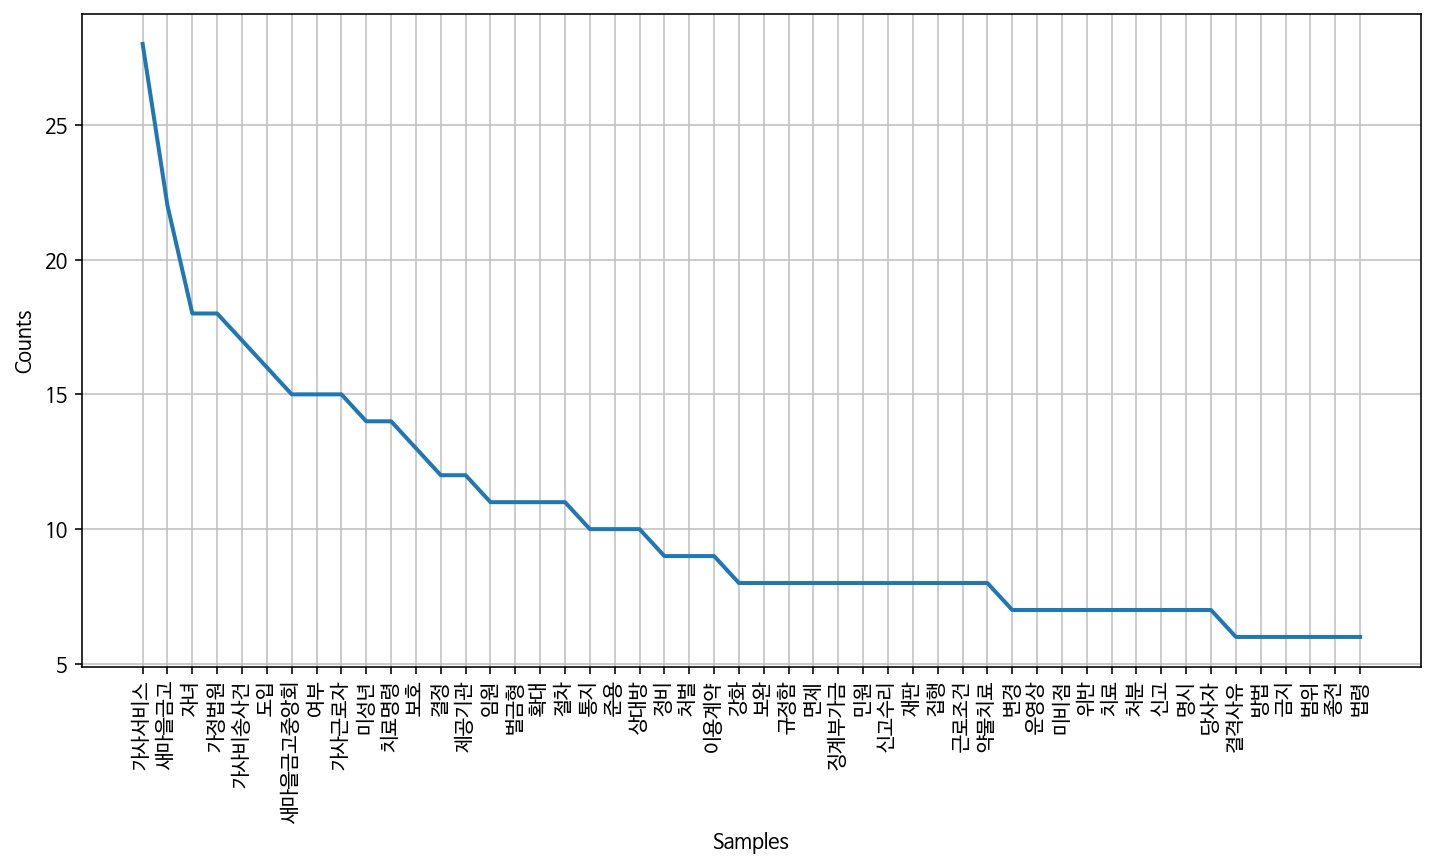

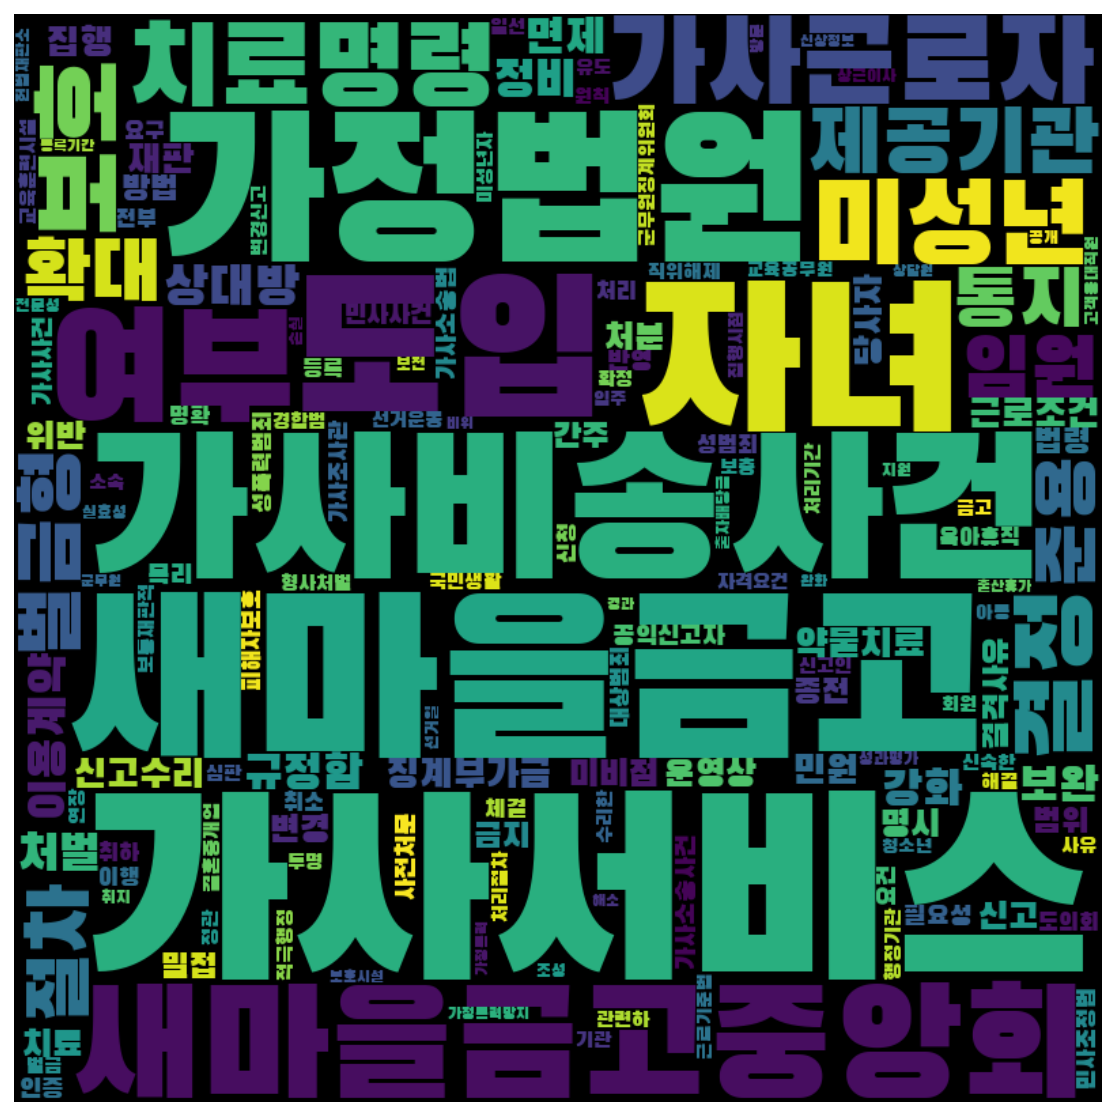

In [153]:
government_word = total_tokens(government['tokens'])

stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출','신설','한편','문제','지급','제공','항제','사용','근거','대상',
            '이유','증가','제도','사업','정책','우리나라','행위','특례법','불구','수준','추가','관리','확보','의무','업무','문장']
government_word = [each_word for each_word in government_word if each_word not in stopwords]

frewords_vis(government_word)
wordcloud_vis(government_word)